In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

In [4]:
bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## VAE Model
![](https://velog.velcdn.com/images/onground/post/0aa95c10-f56f-43b0-bd22-46f302a4c92f/image.png)

In [3]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim, z_dim):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(x_dim, h_dim)
        self.fc2_mu = nn.Linear(h_dim, z_dim)
        self.fc2_logvar = nn.Linear(h_dim, z_dim)

        # Decoder
        self.fc3 = nn.Linear(z_dim, h_dim)
        self.fc4 = nn.Linear(h_dim, x_dim)

    def encoder(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2_mu(h), self.fc2_logvar(h)

    def sampling(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample

    def decoder(self, z):
        h = F.relu(self.fc3(z))
        return F.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, logvar)
        return self.decoder(z), mu, logvar

In [6]:
vae = VAE(x_dim=784, h_dim=400, z_dim=20).to(device)
print(vae)

VAE(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc2_mu): Linear(in_features=400, out_features=20, bias=True)
  (fc2_logvar): Linear(in_features=400, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=784, bias=True)
)


In [8]:
optimizer = optim.Adam(vae.parameters(), lr=0.001)

# reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

## Training

In [11]:
from tqdm.notebook import tqdm

In [12]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in tqdm(enumerate(train_loader)):
        data = data.to(device)
        optimizer.zero_grad()

        recon_batch, mu, logvar = vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(train_loader.dataset)))

In [13]:
def test():
    vae.eval()
    test_loss = 0

    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon_batch, mu, logvar = vae(data)

            test_loss += loss_function(recon_batch, data, mu, logvar).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [14]:
for epoch in range(1, 51):
    train(epoch)
    test()

0it [00:00, ?it/s]

/home/hjs/anaconda3/envs/pytorch_env/lib/python3.10/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000 (0%)]	Loss: 548.489531
Train Epoch: 1 [1000/60000 (2%)]	Loss: 290.457988
Train Epoch: 1 [2000/60000 (3%)]	Loss: 241.182656
Train Epoch: 1 [3000/60000 (5%)]	Loss: 221.756816
Train Epoch: 1 [4000/60000 (7%)]	Loss: 215.371914
Train Epoch: 1 [5000/60000 (8%)]	Loss: 210.638301
Train Epoch: 1 [6000/60000 (10%)]	Loss: 209.353145
Train Epoch: 1 [7000/60000 (12%)]	Loss: 201.589492
Train Epoch: 1 [8000/60000 (13%)]	Loss: 203.035020
Train Epoch: 1 [9000/60000 (15%)]	Loss: 192.595430
Train Epoch: 1 [10000/60000 (17%)]	Loss: 182.929922
Train Epoch: 1 [11000/60000 (18%)]	Loss: 185.172188
Train Epoch: 1 [12000/60000 (20%)]	Loss: 182.139414
Train Epoch: 1 [13000/60000 (22%)]	Loss: 168.534375
Train Epoch: 1 [14000/60000 (23%)]	Loss: 165.605098
Train Epoch: 1 [15000/60000 (25%)]	Loss: 158.870488
Train Epoch: 1 [16000/60000 (27%)]	Loss: 161.238984
Train Epoch: 1 [17000/60000 (28%)]	Loss: 161.217266
Train Epoch: 1 [18000/60000 (30%)]	Loss: 156.999004
Train Epoch: 1 [19000/60000 (32

0it [00:00, ?it/s]

Train Epoch: 2 [0/60000 (0%)]	Loss: 125.869580
Train Epoch: 2 [1000/60000 (2%)]	Loss: 125.028721
Train Epoch: 2 [2000/60000 (3%)]	Loss: 127.983086
Train Epoch: 2 [3000/60000 (5%)]	Loss: 127.767266
Train Epoch: 2 [4000/60000 (7%)]	Loss: 128.060762
Train Epoch: 2 [5000/60000 (8%)]	Loss: 126.683262
Train Epoch: 2 [6000/60000 (10%)]	Loss: 120.070918
Train Epoch: 2 [7000/60000 (12%)]	Loss: 115.883555
Train Epoch: 2 [8000/60000 (13%)]	Loss: 118.328809
Train Epoch: 2 [9000/60000 (15%)]	Loss: 122.599473
Train Epoch: 2 [10000/60000 (17%)]	Loss: 123.739141
Train Epoch: 2 [11000/60000 (18%)]	Loss: 125.451650
Train Epoch: 2 [12000/60000 (20%)]	Loss: 124.374746
Train Epoch: 2 [13000/60000 (22%)]	Loss: 121.797930
Train Epoch: 2 [14000/60000 (23%)]	Loss: 119.619375
Train Epoch: 2 [15000/60000 (25%)]	Loss: 121.505410
Train Epoch: 2 [16000/60000 (27%)]	Loss: 119.214141
Train Epoch: 2 [17000/60000 (28%)]	Loss: 124.424355
Train Epoch: 2 [18000/60000 (30%)]	Loss: 121.952754
Train Epoch: 2 [19000/60000 (32

0it [00:00, ?it/s]

Train Epoch: 3 [0/60000 (0%)]	Loss: 116.131953
Train Epoch: 3 [1000/60000 (2%)]	Loss: 111.860371
Train Epoch: 3 [2000/60000 (3%)]	Loss: 115.480127
Train Epoch: 3 [3000/60000 (5%)]	Loss: 115.820332
Train Epoch: 3 [4000/60000 (7%)]	Loss: 112.680850
Train Epoch: 3 [5000/60000 (8%)]	Loss: 113.086562
Train Epoch: 3 [6000/60000 (10%)]	Loss: 116.478281
Train Epoch: 3 [7000/60000 (12%)]	Loss: 116.626719
Train Epoch: 3 [8000/60000 (13%)]	Loss: 115.290312
Train Epoch: 3 [9000/60000 (15%)]	Loss: 113.563125
Train Epoch: 3 [10000/60000 (17%)]	Loss: 113.730850
Train Epoch: 3 [11000/60000 (18%)]	Loss: 116.175547
Train Epoch: 3 [12000/60000 (20%)]	Loss: 113.982803
Train Epoch: 3 [13000/60000 (22%)]	Loss: 110.511387
Train Epoch: 3 [14000/60000 (23%)]	Loss: 118.813428
Train Epoch: 3 [15000/60000 (25%)]	Loss: 113.569521
Train Epoch: 3 [16000/60000 (27%)]	Loss: 108.828027
Train Epoch: 3 [17000/60000 (28%)]	Loss: 115.361143
Train Epoch: 3 [18000/60000 (30%)]	Loss: 109.460771
Train Epoch: 3 [19000/60000 (32

0it [00:00, ?it/s]

Train Epoch: 4 [0/60000 (0%)]	Loss: 114.482988
Train Epoch: 4 [1000/60000 (2%)]	Loss: 111.833477
Train Epoch: 4 [2000/60000 (3%)]	Loss: 111.326260
Train Epoch: 4 [3000/60000 (5%)]	Loss: 111.237725
Train Epoch: 4 [4000/60000 (7%)]	Loss: 106.778594
Train Epoch: 4 [5000/60000 (8%)]	Loss: 112.236396
Train Epoch: 4 [6000/60000 (10%)]	Loss: 114.351660
Train Epoch: 4 [7000/60000 (12%)]	Loss: 109.477187
Train Epoch: 4 [8000/60000 (13%)]	Loss: 110.441074
Train Epoch: 4 [9000/60000 (15%)]	Loss: 109.370547
Train Epoch: 4 [10000/60000 (17%)]	Loss: 109.118516
Train Epoch: 4 [11000/60000 (18%)]	Loss: 112.094053
Train Epoch: 4 [12000/60000 (20%)]	Loss: 111.667930
Train Epoch: 4 [13000/60000 (22%)]	Loss: 101.236309
Train Epoch: 4 [14000/60000 (23%)]	Loss: 114.880957
Train Epoch: 4 [15000/60000 (25%)]	Loss: 112.047207
Train Epoch: 4 [16000/60000 (27%)]	Loss: 107.584287
Train Epoch: 4 [17000/60000 (28%)]	Loss: 110.554082
Train Epoch: 4 [18000/60000 (30%)]	Loss: 111.768213
Train Epoch: 4 [19000/60000 (32

0it [00:00, ?it/s]

Train Epoch: 5 [0/60000 (0%)]	Loss: 109.947285
Train Epoch: 5 [1000/60000 (2%)]	Loss: 110.458213
Train Epoch: 5 [2000/60000 (3%)]	Loss: 113.900254
Train Epoch: 5 [3000/60000 (5%)]	Loss: 114.289434
Train Epoch: 5 [4000/60000 (7%)]	Loss: 109.059971
Train Epoch: 5 [5000/60000 (8%)]	Loss: 107.418145
Train Epoch: 5 [6000/60000 (10%)]	Loss: 109.386221
Train Epoch: 5 [7000/60000 (12%)]	Loss: 112.570010
Train Epoch: 5 [8000/60000 (13%)]	Loss: 111.856494
Train Epoch: 5 [9000/60000 (15%)]	Loss: 107.580625
Train Epoch: 5 [10000/60000 (17%)]	Loss: 110.053584
Train Epoch: 5 [11000/60000 (18%)]	Loss: 111.717422
Train Epoch: 5 [12000/60000 (20%)]	Loss: 114.497070
Train Epoch: 5 [13000/60000 (22%)]	Loss: 108.030449
Train Epoch: 5 [14000/60000 (23%)]	Loss: 111.758682
Train Epoch: 5 [15000/60000 (25%)]	Loss: 106.133281
Train Epoch: 5 [16000/60000 (27%)]	Loss: 108.846416
Train Epoch: 5 [17000/60000 (28%)]	Loss: 110.823008
Train Epoch: 5 [18000/60000 (30%)]	Loss: 105.527334
Train Epoch: 5 [19000/60000 (32

0it [00:00, ?it/s]

Train Epoch: 6 [0/60000 (0%)]	Loss: 108.071260
Train Epoch: 6 [1000/60000 (2%)]	Loss: 105.990039
Train Epoch: 6 [2000/60000 (3%)]	Loss: 110.467676
Train Epoch: 6 [3000/60000 (5%)]	Loss: 104.934678
Train Epoch: 6 [4000/60000 (7%)]	Loss: 108.043750
Train Epoch: 6 [5000/60000 (8%)]	Loss: 108.934785
Train Epoch: 6 [6000/60000 (10%)]	Loss: 106.838613
Train Epoch: 6 [7000/60000 (12%)]	Loss: 110.057070
Train Epoch: 6 [8000/60000 (13%)]	Loss: 106.964980
Train Epoch: 6 [9000/60000 (15%)]	Loss: 110.267109
Train Epoch: 6 [10000/60000 (17%)]	Loss: 109.286143
Train Epoch: 6 [11000/60000 (18%)]	Loss: 110.794121
Train Epoch: 6 [12000/60000 (20%)]	Loss: 110.533848
Train Epoch: 6 [13000/60000 (22%)]	Loss: 105.361309
Train Epoch: 6 [14000/60000 (23%)]	Loss: 108.197324
Train Epoch: 6 [15000/60000 (25%)]	Loss: 106.762705
Train Epoch: 6 [16000/60000 (27%)]	Loss: 105.478203
Train Epoch: 6 [17000/60000 (28%)]	Loss: 112.898984
Train Epoch: 6 [18000/60000 (30%)]	Loss: 104.201992
Train Epoch: 6 [19000/60000 (32

0it [00:00, ?it/s]

Train Epoch: 7 [0/60000 (0%)]	Loss: 105.435234
Train Epoch: 7 [1000/60000 (2%)]	Loss: 107.083945
Train Epoch: 7 [2000/60000 (3%)]	Loss: 106.116680
Train Epoch: 7 [3000/60000 (5%)]	Loss: 110.103809
Train Epoch: 7 [4000/60000 (7%)]	Loss: 105.943105
Train Epoch: 7 [5000/60000 (8%)]	Loss: 102.794160
Train Epoch: 7 [6000/60000 (10%)]	Loss: 107.895059
Train Epoch: 7 [7000/60000 (12%)]	Loss: 108.528154
Train Epoch: 7 [8000/60000 (13%)]	Loss: 111.823574
Train Epoch: 7 [9000/60000 (15%)]	Loss: 107.837578
Train Epoch: 7 [10000/60000 (17%)]	Loss: 105.646367
Train Epoch: 7 [11000/60000 (18%)]	Loss: 108.618594
Train Epoch: 7 [12000/60000 (20%)]	Loss: 110.159336
Train Epoch: 7 [13000/60000 (22%)]	Loss: 106.977295
Train Epoch: 7 [14000/60000 (23%)]	Loss: 109.510312
Train Epoch: 7 [15000/60000 (25%)]	Loss: 108.914180
Train Epoch: 7 [16000/60000 (27%)]	Loss: 106.535049
Train Epoch: 7 [17000/60000 (28%)]	Loss: 102.268770
Train Epoch: 7 [18000/60000 (30%)]	Loss: 109.550693
Train Epoch: 7 [19000/60000 (32

0it [00:00, ?it/s]

Train Epoch: 8 [0/60000 (0%)]	Loss: 106.103809
Train Epoch: 8 [1000/60000 (2%)]	Loss: 107.380762
Train Epoch: 8 [2000/60000 (3%)]	Loss: 107.257656
Train Epoch: 8 [3000/60000 (5%)]	Loss: 105.397656
Train Epoch: 8 [4000/60000 (7%)]	Loss: 108.499570
Train Epoch: 8 [5000/60000 (8%)]	Loss: 106.971738
Train Epoch: 8 [6000/60000 (10%)]	Loss: 107.327021
Train Epoch: 8 [7000/60000 (12%)]	Loss: 104.826992
Train Epoch: 8 [8000/60000 (13%)]	Loss: 112.231602
Train Epoch: 8 [9000/60000 (15%)]	Loss: 109.556777
Train Epoch: 8 [10000/60000 (17%)]	Loss: 109.792969
Train Epoch: 8 [11000/60000 (18%)]	Loss: 103.145176
Train Epoch: 8 [12000/60000 (20%)]	Loss: 106.604258
Train Epoch: 8 [13000/60000 (22%)]	Loss: 107.906777
Train Epoch: 8 [14000/60000 (23%)]	Loss: 103.184346
Train Epoch: 8 [15000/60000 (25%)]	Loss: 107.153135
Train Epoch: 8 [16000/60000 (27%)]	Loss: 106.446113
Train Epoch: 8 [17000/60000 (28%)]	Loss: 105.112676
Train Epoch: 8 [18000/60000 (30%)]	Loss: 107.920898
Train Epoch: 8 [19000/60000 (32

0it [00:00, ?it/s]

Train Epoch: 9 [0/60000 (0%)]	Loss: 105.132559
Train Epoch: 9 [1000/60000 (2%)]	Loss: 105.183340
Train Epoch: 9 [2000/60000 (3%)]	Loss: 109.059082
Train Epoch: 9 [3000/60000 (5%)]	Loss: 108.746631
Train Epoch: 9 [4000/60000 (7%)]	Loss: 100.885029
Train Epoch: 9 [5000/60000 (8%)]	Loss: 103.753125
Train Epoch: 9 [6000/60000 (10%)]	Loss: 104.881875
Train Epoch: 9 [7000/60000 (12%)]	Loss: 108.262070
Train Epoch: 9 [8000/60000 (13%)]	Loss: 100.203896
Train Epoch: 9 [9000/60000 (15%)]	Loss: 106.373691
Train Epoch: 9 [10000/60000 (17%)]	Loss: 106.970410
Train Epoch: 9 [11000/60000 (18%)]	Loss: 108.203125
Train Epoch: 9 [12000/60000 (20%)]	Loss: 106.665459
Train Epoch: 9 [13000/60000 (22%)]	Loss: 109.878740
Train Epoch: 9 [14000/60000 (23%)]	Loss: 105.387314
Train Epoch: 9 [15000/60000 (25%)]	Loss: 109.348232
Train Epoch: 9 [16000/60000 (27%)]	Loss: 100.435293
Train Epoch: 9 [17000/60000 (28%)]	Loss: 106.716885
Train Epoch: 9 [18000/60000 (30%)]	Loss: 109.472197
Train Epoch: 9 [19000/60000 (32

0it [00:00, ?it/s]

Train Epoch: 10 [0/60000 (0%)]	Loss: 104.552422
Train Epoch: 10 [1000/60000 (2%)]	Loss: 111.117031
Train Epoch: 10 [2000/60000 (3%)]	Loss: 104.296953
Train Epoch: 10 [3000/60000 (5%)]	Loss: 104.598516
Train Epoch: 10 [4000/60000 (7%)]	Loss: 105.523721
Train Epoch: 10 [5000/60000 (8%)]	Loss: 106.366309
Train Epoch: 10 [6000/60000 (10%)]	Loss: 103.631289
Train Epoch: 10 [7000/60000 (12%)]	Loss: 102.106250
Train Epoch: 10 [8000/60000 (13%)]	Loss: 108.616543
Train Epoch: 10 [9000/60000 (15%)]	Loss: 105.240723
Train Epoch: 10 [10000/60000 (17%)]	Loss: 100.364004
Train Epoch: 10 [11000/60000 (18%)]	Loss: 107.972949
Train Epoch: 10 [12000/60000 (20%)]	Loss: 104.210791
Train Epoch: 10 [13000/60000 (22%)]	Loss: 105.587129
Train Epoch: 10 [14000/60000 (23%)]	Loss: 107.057109
Train Epoch: 10 [15000/60000 (25%)]	Loss: 109.865566
Train Epoch: 10 [16000/60000 (27%)]	Loss: 105.849238
Train Epoch: 10 [17000/60000 (28%)]	Loss: 105.755977
Train Epoch: 10 [18000/60000 (30%)]	Loss: 108.292207
Train Epoch:

0it [00:00, ?it/s]

Train Epoch: 11 [0/60000 (0%)]	Loss: 104.185566
Train Epoch: 11 [1000/60000 (2%)]	Loss: 105.772949
Train Epoch: 11 [2000/60000 (3%)]	Loss: 98.078164
Train Epoch: 11 [3000/60000 (5%)]	Loss: 103.920801
Train Epoch: 11 [4000/60000 (7%)]	Loss: 104.840020
Train Epoch: 11 [5000/60000 (8%)]	Loss: 106.139824
Train Epoch: 11 [6000/60000 (10%)]	Loss: 101.308643
Train Epoch: 11 [7000/60000 (12%)]	Loss: 108.182207
Train Epoch: 11 [8000/60000 (13%)]	Loss: 104.326270
Train Epoch: 11 [9000/60000 (15%)]	Loss: 102.980850
Train Epoch: 11 [10000/60000 (17%)]	Loss: 107.411172
Train Epoch: 11 [11000/60000 (18%)]	Loss: 103.022920
Train Epoch: 11 [12000/60000 (20%)]	Loss: 103.534805
Train Epoch: 11 [13000/60000 (22%)]	Loss: 109.346631
Train Epoch: 11 [14000/60000 (23%)]	Loss: 107.904355
Train Epoch: 11 [15000/60000 (25%)]	Loss: 101.683477
Train Epoch: 11 [16000/60000 (27%)]	Loss: 105.801240
Train Epoch: 11 [17000/60000 (28%)]	Loss: 103.978203
Train Epoch: 11 [18000/60000 (30%)]	Loss: 108.779492
Train Epoch: 

0it [00:00, ?it/s]

Train Epoch: 12 [0/60000 (0%)]	Loss: 107.666123
Train Epoch: 12 [1000/60000 (2%)]	Loss: 104.712930
Train Epoch: 12 [2000/60000 (3%)]	Loss: 103.463086
Train Epoch: 12 [3000/60000 (5%)]	Loss: 108.844844
Train Epoch: 12 [4000/60000 (7%)]	Loss: 107.606445
Train Epoch: 12 [5000/60000 (8%)]	Loss: 108.810117
Train Epoch: 12 [6000/60000 (10%)]	Loss: 102.869863
Train Epoch: 12 [7000/60000 (12%)]	Loss: 104.838262
Train Epoch: 12 [8000/60000 (13%)]	Loss: 107.172598
Train Epoch: 12 [9000/60000 (15%)]	Loss: 110.107568
Train Epoch: 12 [10000/60000 (17%)]	Loss: 106.658828
Train Epoch: 12 [11000/60000 (18%)]	Loss: 103.964180
Train Epoch: 12 [12000/60000 (20%)]	Loss: 103.339502
Train Epoch: 12 [13000/60000 (22%)]	Loss: 102.280937
Train Epoch: 12 [14000/60000 (23%)]	Loss: 101.022314
Train Epoch: 12 [15000/60000 (25%)]	Loss: 102.219805
Train Epoch: 12 [16000/60000 (27%)]	Loss: 104.377695
Train Epoch: 12 [17000/60000 (28%)]	Loss: 103.181846
Train Epoch: 12 [18000/60000 (30%)]	Loss: 104.046299
Train Epoch:

0it [00:00, ?it/s]

Train Epoch: 13 [0/60000 (0%)]	Loss: 105.658105
Train Epoch: 13 [1000/60000 (2%)]	Loss: 103.598594
Train Epoch: 13 [2000/60000 (3%)]	Loss: 105.496299
Train Epoch: 13 [3000/60000 (5%)]	Loss: 108.011465
Train Epoch: 13 [4000/60000 (7%)]	Loss: 109.779600
Train Epoch: 13 [5000/60000 (8%)]	Loss: 109.142344
Train Epoch: 13 [6000/60000 (10%)]	Loss: 107.810586
Train Epoch: 13 [7000/60000 (12%)]	Loss: 100.849756
Train Epoch: 13 [8000/60000 (13%)]	Loss: 104.595098
Train Epoch: 13 [9000/60000 (15%)]	Loss: 103.796582
Train Epoch: 13 [10000/60000 (17%)]	Loss: 104.725820
Train Epoch: 13 [11000/60000 (18%)]	Loss: 108.676943
Train Epoch: 13 [12000/60000 (20%)]	Loss: 107.193994
Train Epoch: 13 [13000/60000 (22%)]	Loss: 105.311357
Train Epoch: 13 [14000/60000 (23%)]	Loss: 102.424385
Train Epoch: 13 [15000/60000 (25%)]	Loss: 106.357588
Train Epoch: 13 [16000/60000 (27%)]	Loss: 103.980254
Train Epoch: 13 [17000/60000 (28%)]	Loss: 104.914062
Train Epoch: 13 [18000/60000 (30%)]	Loss: 99.318350
Train Epoch: 

0it [00:00, ?it/s]

Train Epoch: 14 [0/60000 (0%)]	Loss: 104.134189
Train Epoch: 14 [1000/60000 (2%)]	Loss: 105.183115
Train Epoch: 14 [2000/60000 (3%)]	Loss: 103.373896
Train Epoch: 14 [3000/60000 (5%)]	Loss: 106.129512
Train Epoch: 14 [4000/60000 (7%)]	Loss: 104.484453
Train Epoch: 14 [5000/60000 (8%)]	Loss: 103.617969
Train Epoch: 14 [6000/60000 (10%)]	Loss: 102.561855
Train Epoch: 14 [7000/60000 (12%)]	Loss: 103.072012
Train Epoch: 14 [8000/60000 (13%)]	Loss: 104.004922
Train Epoch: 14 [9000/60000 (15%)]	Loss: 107.631406
Train Epoch: 14 [10000/60000 (17%)]	Loss: 108.564375
Train Epoch: 14 [11000/60000 (18%)]	Loss: 105.117188
Train Epoch: 14 [12000/60000 (20%)]	Loss: 108.985664
Train Epoch: 14 [13000/60000 (22%)]	Loss: 106.484180
Train Epoch: 14 [14000/60000 (23%)]	Loss: 107.654033
Train Epoch: 14 [15000/60000 (25%)]	Loss: 106.638594
Train Epoch: 14 [16000/60000 (27%)]	Loss: 102.865449
Train Epoch: 14 [17000/60000 (28%)]	Loss: 104.050225
Train Epoch: 14 [18000/60000 (30%)]	Loss: 104.080576
Train Epoch:

0it [00:00, ?it/s]

Train Epoch: 15 [0/60000 (0%)]	Loss: 104.428184
Train Epoch: 15 [1000/60000 (2%)]	Loss: 103.297207
Train Epoch: 15 [2000/60000 (3%)]	Loss: 101.478594
Train Epoch: 15 [3000/60000 (5%)]	Loss: 107.850313
Train Epoch: 15 [4000/60000 (7%)]	Loss: 103.015693
Train Epoch: 15 [5000/60000 (8%)]	Loss: 101.170361
Train Epoch: 15 [6000/60000 (10%)]	Loss: 109.374473
Train Epoch: 15 [7000/60000 (12%)]	Loss: 108.569482
Train Epoch: 15 [8000/60000 (13%)]	Loss: 99.141953
Train Epoch: 15 [9000/60000 (15%)]	Loss: 102.074102
Train Epoch: 15 [10000/60000 (17%)]	Loss: 102.655996
Train Epoch: 15 [11000/60000 (18%)]	Loss: 101.037705
Train Epoch: 15 [12000/60000 (20%)]	Loss: 103.758896
Train Epoch: 15 [13000/60000 (22%)]	Loss: 101.821318
Train Epoch: 15 [14000/60000 (23%)]	Loss: 103.904609
Train Epoch: 15 [15000/60000 (25%)]	Loss: 102.403740
Train Epoch: 15 [16000/60000 (27%)]	Loss: 107.014707
Train Epoch: 15 [17000/60000 (28%)]	Loss: 104.825547
Train Epoch: 15 [18000/60000 (30%)]	Loss: 104.453340
Train Epoch: 

0it [00:00, ?it/s]

Train Epoch: 16 [0/60000 (0%)]	Loss: 105.572510
Train Epoch: 16 [1000/60000 (2%)]	Loss: 104.457012
Train Epoch: 16 [2000/60000 (3%)]	Loss: 101.010918
Train Epoch: 16 [3000/60000 (5%)]	Loss: 104.499521
Train Epoch: 16 [4000/60000 (7%)]	Loss: 100.659658
Train Epoch: 16 [5000/60000 (8%)]	Loss: 101.251074
Train Epoch: 16 [6000/60000 (10%)]	Loss: 104.962344
Train Epoch: 16 [7000/60000 (12%)]	Loss: 106.795547
Train Epoch: 16 [8000/60000 (13%)]	Loss: 102.392383
Train Epoch: 16 [9000/60000 (15%)]	Loss: 103.397363
Train Epoch: 16 [10000/60000 (17%)]	Loss: 101.095273
Train Epoch: 16 [11000/60000 (18%)]	Loss: 104.679824
Train Epoch: 16 [12000/60000 (20%)]	Loss: 103.447266
Train Epoch: 16 [13000/60000 (22%)]	Loss: 106.706348
Train Epoch: 16 [14000/60000 (23%)]	Loss: 101.549434
Train Epoch: 16 [15000/60000 (25%)]	Loss: 97.517783
Train Epoch: 16 [16000/60000 (27%)]	Loss: 102.281055
Train Epoch: 16 [17000/60000 (28%)]	Loss: 101.617861
Train Epoch: 16 [18000/60000 (30%)]	Loss: 104.890732
Train Epoch: 

0it [00:00, ?it/s]

Train Epoch: 17 [0/60000 (0%)]	Loss: 108.597500
Train Epoch: 17 [1000/60000 (2%)]	Loss: 103.062012
Train Epoch: 17 [2000/60000 (3%)]	Loss: 101.013320
Train Epoch: 17 [3000/60000 (5%)]	Loss: 103.112559
Train Epoch: 17 [4000/60000 (7%)]	Loss: 105.606699
Train Epoch: 17 [5000/60000 (8%)]	Loss: 104.994570
Train Epoch: 17 [6000/60000 (10%)]	Loss: 104.932598
Train Epoch: 17 [7000/60000 (12%)]	Loss: 100.940117
Train Epoch: 17 [8000/60000 (13%)]	Loss: 102.101670
Train Epoch: 17 [9000/60000 (15%)]	Loss: 103.066875
Train Epoch: 17 [10000/60000 (17%)]	Loss: 100.250801
Train Epoch: 17 [11000/60000 (18%)]	Loss: 106.107041
Train Epoch: 17 [12000/60000 (20%)]	Loss: 106.462363
Train Epoch: 17 [13000/60000 (22%)]	Loss: 103.582988
Train Epoch: 17 [14000/60000 (23%)]	Loss: 100.340977
Train Epoch: 17 [15000/60000 (25%)]	Loss: 103.236152
Train Epoch: 17 [16000/60000 (27%)]	Loss: 101.228467
Train Epoch: 17 [17000/60000 (28%)]	Loss: 106.292949
Train Epoch: 17 [18000/60000 (30%)]	Loss: 105.398799
Train Epoch:

0it [00:00, ?it/s]

Train Epoch: 18 [0/60000 (0%)]	Loss: 103.318086
Train Epoch: 18 [1000/60000 (2%)]	Loss: 104.846240
Train Epoch: 18 [2000/60000 (3%)]	Loss: 106.792148
Train Epoch: 18 [3000/60000 (5%)]	Loss: 105.741270
Train Epoch: 18 [4000/60000 (7%)]	Loss: 106.986191
Train Epoch: 18 [5000/60000 (8%)]	Loss: 106.040342
Train Epoch: 18 [6000/60000 (10%)]	Loss: 105.100430
Train Epoch: 18 [7000/60000 (12%)]	Loss: 107.159629
Train Epoch: 18 [8000/60000 (13%)]	Loss: 105.003145
Train Epoch: 18 [9000/60000 (15%)]	Loss: 99.659238
Train Epoch: 18 [10000/60000 (17%)]	Loss: 104.585254
Train Epoch: 18 [11000/60000 (18%)]	Loss: 108.245283
Train Epoch: 18 [12000/60000 (20%)]	Loss: 104.984629
Train Epoch: 18 [13000/60000 (22%)]	Loss: 101.193047
Train Epoch: 18 [14000/60000 (23%)]	Loss: 103.404570
Train Epoch: 18 [15000/60000 (25%)]	Loss: 107.544336
Train Epoch: 18 [16000/60000 (27%)]	Loss: 106.378887
Train Epoch: 18 [17000/60000 (28%)]	Loss: 99.857969
Train Epoch: 18 [18000/60000 (30%)]	Loss: 101.393730
Train Epoch: 1

0it [00:00, ?it/s]

Train Epoch: 19 [0/60000 (0%)]	Loss: 106.683027
Train Epoch: 19 [1000/60000 (2%)]	Loss: 103.075469
Train Epoch: 19 [2000/60000 (3%)]	Loss: 100.643066
Train Epoch: 19 [3000/60000 (5%)]	Loss: 101.599570
Train Epoch: 19 [4000/60000 (7%)]	Loss: 101.498945
Train Epoch: 19 [5000/60000 (8%)]	Loss: 104.538652
Train Epoch: 19 [6000/60000 (10%)]	Loss: 105.816699
Train Epoch: 19 [7000/60000 (12%)]	Loss: 103.545039
Train Epoch: 19 [8000/60000 (13%)]	Loss: 106.530254
Train Epoch: 19 [9000/60000 (15%)]	Loss: 102.013730
Train Epoch: 19 [10000/60000 (17%)]	Loss: 105.871777
Train Epoch: 19 [11000/60000 (18%)]	Loss: 103.775186
Train Epoch: 19 [12000/60000 (20%)]	Loss: 106.713545
Train Epoch: 19 [13000/60000 (22%)]	Loss: 102.472891
Train Epoch: 19 [14000/60000 (23%)]	Loss: 103.841699
Train Epoch: 19 [15000/60000 (25%)]	Loss: 104.924482
Train Epoch: 19 [16000/60000 (27%)]	Loss: 103.471533
Train Epoch: 19 [17000/60000 (28%)]	Loss: 99.987295
Train Epoch: 19 [18000/60000 (30%)]	Loss: 101.912559
Train Epoch: 

0it [00:00, ?it/s]

Train Epoch: 20 [0/60000 (0%)]	Loss: 105.531240
Train Epoch: 20 [1000/60000 (2%)]	Loss: 102.429180
Train Epoch: 20 [2000/60000 (3%)]	Loss: 104.734863
Train Epoch: 20 [3000/60000 (5%)]	Loss: 102.674961
Train Epoch: 20 [4000/60000 (7%)]	Loss: 99.148516
Train Epoch: 20 [5000/60000 (8%)]	Loss: 100.642764
Train Epoch: 20 [6000/60000 (10%)]	Loss: 107.290605
Train Epoch: 20 [7000/60000 (12%)]	Loss: 101.564805
Train Epoch: 20 [8000/60000 (13%)]	Loss: 106.137090
Train Epoch: 20 [9000/60000 (15%)]	Loss: 103.984092
Train Epoch: 20 [10000/60000 (17%)]	Loss: 105.383633
Train Epoch: 20 [11000/60000 (18%)]	Loss: 103.544863
Train Epoch: 20 [12000/60000 (20%)]	Loss: 105.249307
Train Epoch: 20 [13000/60000 (22%)]	Loss: 106.771816
Train Epoch: 20 [14000/60000 (23%)]	Loss: 106.869668
Train Epoch: 20 [15000/60000 (25%)]	Loss: 107.387480
Train Epoch: 20 [16000/60000 (27%)]	Loss: 103.117324
Train Epoch: 20 [17000/60000 (28%)]	Loss: 102.284043
Train Epoch: 20 [18000/60000 (30%)]	Loss: 104.571084
Train Epoch: 

0it [00:00, ?it/s]

Train Epoch: 21 [0/60000 (0%)]	Loss: 101.672422
Train Epoch: 21 [1000/60000 (2%)]	Loss: 104.808594
Train Epoch: 21 [2000/60000 (3%)]	Loss: 101.657461
Train Epoch: 21 [3000/60000 (5%)]	Loss: 104.045908
Train Epoch: 21 [4000/60000 (7%)]	Loss: 100.405439
Train Epoch: 21 [5000/60000 (8%)]	Loss: 105.109785
Train Epoch: 21 [6000/60000 (10%)]	Loss: 103.262676
Train Epoch: 21 [7000/60000 (12%)]	Loss: 103.829434
Train Epoch: 21 [8000/60000 (13%)]	Loss: 102.988242
Train Epoch: 21 [9000/60000 (15%)]	Loss: 101.597949
Train Epoch: 21 [10000/60000 (17%)]	Loss: 104.534023
Train Epoch: 21 [11000/60000 (18%)]	Loss: 101.958262
Train Epoch: 21 [12000/60000 (20%)]	Loss: 106.430127
Train Epoch: 21 [13000/60000 (22%)]	Loss: 103.790059
Train Epoch: 21 [14000/60000 (23%)]	Loss: 100.577490
Train Epoch: 21 [15000/60000 (25%)]	Loss: 99.743311
Train Epoch: 21 [16000/60000 (27%)]	Loss: 105.786416
Train Epoch: 21 [17000/60000 (28%)]	Loss: 105.265986
Train Epoch: 21 [18000/60000 (30%)]	Loss: 106.646846
Train Epoch: 

0it [00:00, ?it/s]

Train Epoch: 22 [0/60000 (0%)]	Loss: 103.104893
Train Epoch: 22 [1000/60000 (2%)]	Loss: 104.329863
Train Epoch: 22 [2000/60000 (3%)]	Loss: 106.606846
Train Epoch: 22 [3000/60000 (5%)]	Loss: 101.353359
Train Epoch: 22 [4000/60000 (7%)]	Loss: 104.851992
Train Epoch: 22 [5000/60000 (8%)]	Loss: 101.404307
Train Epoch: 22 [6000/60000 (10%)]	Loss: 105.177939
Train Epoch: 22 [7000/60000 (12%)]	Loss: 97.992754
Train Epoch: 22 [8000/60000 (13%)]	Loss: 95.296338
Train Epoch: 22 [9000/60000 (15%)]	Loss: 104.162188
Train Epoch: 22 [10000/60000 (17%)]	Loss: 106.059600
Train Epoch: 22 [11000/60000 (18%)]	Loss: 102.248682
Train Epoch: 22 [12000/60000 (20%)]	Loss: 103.837363
Train Epoch: 22 [13000/60000 (22%)]	Loss: 103.937129
Train Epoch: 22 [14000/60000 (23%)]	Loss: 107.696504
Train Epoch: 22 [15000/60000 (25%)]	Loss: 101.717451
Train Epoch: 22 [16000/60000 (27%)]	Loss: 103.925508
Train Epoch: 22 [17000/60000 (28%)]	Loss: 105.890566
Train Epoch: 22 [18000/60000 (30%)]	Loss: 103.808545
Train Epoch: 2

0it [00:00, ?it/s]

Train Epoch: 23 [0/60000 (0%)]	Loss: 100.959375
Train Epoch: 23 [1000/60000 (2%)]	Loss: 107.584727
Train Epoch: 23 [2000/60000 (3%)]	Loss: 103.251416
Train Epoch: 23 [3000/60000 (5%)]	Loss: 100.028721
Train Epoch: 23 [4000/60000 (7%)]	Loss: 105.474629
Train Epoch: 23 [5000/60000 (8%)]	Loss: 102.943945
Train Epoch: 23 [6000/60000 (10%)]	Loss: 105.164258
Train Epoch: 23 [7000/60000 (12%)]	Loss: 102.470020
Train Epoch: 23 [8000/60000 (13%)]	Loss: 101.481895
Train Epoch: 23 [9000/60000 (15%)]	Loss: 106.319844
Train Epoch: 23 [10000/60000 (17%)]	Loss: 102.120615
Train Epoch: 23 [11000/60000 (18%)]	Loss: 105.643027
Train Epoch: 23 [12000/60000 (20%)]	Loss: 100.960430
Train Epoch: 23 [13000/60000 (22%)]	Loss: 103.794746
Train Epoch: 23 [14000/60000 (23%)]	Loss: 101.408398
Train Epoch: 23 [15000/60000 (25%)]	Loss: 102.174678
Train Epoch: 23 [16000/60000 (27%)]	Loss: 98.752500
Train Epoch: 23 [17000/60000 (28%)]	Loss: 102.734004
Train Epoch: 23 [18000/60000 (30%)]	Loss: 102.561230
Train Epoch: 

0it [00:00, ?it/s]

Train Epoch: 24 [0/60000 (0%)]	Loss: 102.077021
Train Epoch: 24 [1000/60000 (2%)]	Loss: 102.469570
Train Epoch: 24 [2000/60000 (3%)]	Loss: 103.617305
Train Epoch: 24 [3000/60000 (5%)]	Loss: 102.477578
Train Epoch: 24 [4000/60000 (7%)]	Loss: 102.055391
Train Epoch: 24 [5000/60000 (8%)]	Loss: 101.194297
Train Epoch: 24 [6000/60000 (10%)]	Loss: 104.777393
Train Epoch: 24 [7000/60000 (12%)]	Loss: 102.954229
Train Epoch: 24 [8000/60000 (13%)]	Loss: 101.641006
Train Epoch: 24 [9000/60000 (15%)]	Loss: 106.948486
Train Epoch: 24 [10000/60000 (17%)]	Loss: 101.495293
Train Epoch: 24 [11000/60000 (18%)]	Loss: 104.398369
Train Epoch: 24 [12000/60000 (20%)]	Loss: 102.034551
Train Epoch: 24 [13000/60000 (22%)]	Loss: 101.728174
Train Epoch: 24 [14000/60000 (23%)]	Loss: 106.301963
Train Epoch: 24 [15000/60000 (25%)]	Loss: 99.814707
Train Epoch: 24 [16000/60000 (27%)]	Loss: 103.921035
Train Epoch: 24 [17000/60000 (28%)]	Loss: 102.952305
Train Epoch: 24 [18000/60000 (30%)]	Loss: 99.412861
Train Epoch: 2

0it [00:00, ?it/s]

Train Epoch: 25 [0/60000 (0%)]	Loss: 103.746504
Train Epoch: 25 [1000/60000 (2%)]	Loss: 103.223086
Train Epoch: 25 [2000/60000 (3%)]	Loss: 101.139258
Train Epoch: 25 [3000/60000 (5%)]	Loss: 99.278516
Train Epoch: 25 [4000/60000 (7%)]	Loss: 105.975117
Train Epoch: 25 [5000/60000 (8%)]	Loss: 102.950645
Train Epoch: 25 [6000/60000 (10%)]	Loss: 108.632344
Train Epoch: 25 [7000/60000 (12%)]	Loss: 99.949111
Train Epoch: 25 [8000/60000 (13%)]	Loss: 102.971885
Train Epoch: 25 [9000/60000 (15%)]	Loss: 106.006309
Train Epoch: 25 [10000/60000 (17%)]	Loss: 103.158945
Train Epoch: 25 [11000/60000 (18%)]	Loss: 104.378730
Train Epoch: 25 [12000/60000 (20%)]	Loss: 101.949219
Train Epoch: 25 [13000/60000 (22%)]	Loss: 102.933945
Train Epoch: 25 [14000/60000 (23%)]	Loss: 103.920625
Train Epoch: 25 [15000/60000 (25%)]	Loss: 100.105039
Train Epoch: 25 [16000/60000 (27%)]	Loss: 97.995791
Train Epoch: 25 [17000/60000 (28%)]	Loss: 103.313223
Train Epoch: 25 [18000/60000 (30%)]	Loss: 102.475195
Train Epoch: 25

0it [00:00, ?it/s]

Train Epoch: 26 [0/60000 (0%)]	Loss: 100.615645
Train Epoch: 26 [1000/60000 (2%)]	Loss: 106.156563
Train Epoch: 26 [2000/60000 (3%)]	Loss: 108.978340
Train Epoch: 26 [3000/60000 (5%)]	Loss: 104.037588
Train Epoch: 26 [4000/60000 (7%)]	Loss: 101.633271
Train Epoch: 26 [5000/60000 (8%)]	Loss: 103.885410
Train Epoch: 26 [6000/60000 (10%)]	Loss: 106.535166
Train Epoch: 26 [7000/60000 (12%)]	Loss: 102.331084
Train Epoch: 26 [8000/60000 (13%)]	Loss: 102.859033
Train Epoch: 26 [9000/60000 (15%)]	Loss: 105.100430
Train Epoch: 26 [10000/60000 (17%)]	Loss: 100.876416
Train Epoch: 26 [11000/60000 (18%)]	Loss: 100.548633
Train Epoch: 26 [12000/60000 (20%)]	Loss: 101.952656
Train Epoch: 26 [13000/60000 (22%)]	Loss: 104.148662
Train Epoch: 26 [14000/60000 (23%)]	Loss: 102.121758
Train Epoch: 26 [15000/60000 (25%)]	Loss: 100.637363
Train Epoch: 26 [16000/60000 (27%)]	Loss: 104.373477
Train Epoch: 26 [17000/60000 (28%)]	Loss: 103.653984
Train Epoch: 26 [18000/60000 (30%)]	Loss: 101.782441
Train Epoch:

0it [00:00, ?it/s]

Train Epoch: 27 [0/60000 (0%)]	Loss: 100.816260
Train Epoch: 27 [1000/60000 (2%)]	Loss: 101.616299
Train Epoch: 27 [2000/60000 (3%)]	Loss: 103.078105
Train Epoch: 27 [3000/60000 (5%)]	Loss: 101.030898
Train Epoch: 27 [4000/60000 (7%)]	Loss: 105.762490
Train Epoch: 27 [5000/60000 (8%)]	Loss: 103.691152
Train Epoch: 27 [6000/60000 (10%)]	Loss: 104.808047
Train Epoch: 27 [7000/60000 (12%)]	Loss: 100.913086
Train Epoch: 27 [8000/60000 (13%)]	Loss: 102.008066
Train Epoch: 27 [9000/60000 (15%)]	Loss: 109.025547
Train Epoch: 27 [10000/60000 (17%)]	Loss: 101.980381
Train Epoch: 27 [11000/60000 (18%)]	Loss: 106.013008
Train Epoch: 27 [12000/60000 (20%)]	Loss: 104.993389
Train Epoch: 27 [13000/60000 (22%)]	Loss: 105.243037
Train Epoch: 27 [14000/60000 (23%)]	Loss: 102.301875
Train Epoch: 27 [15000/60000 (25%)]	Loss: 99.503594
Train Epoch: 27 [16000/60000 (27%)]	Loss: 102.523311
Train Epoch: 27 [17000/60000 (28%)]	Loss: 102.891406
Train Epoch: 27 [18000/60000 (30%)]	Loss: 105.700234
Train Epoch: 

0it [00:00, ?it/s]

Train Epoch: 28 [0/60000 (0%)]	Loss: 104.188340
Train Epoch: 28 [1000/60000 (2%)]	Loss: 103.233184
Train Epoch: 28 [2000/60000 (3%)]	Loss: 105.871787
Train Epoch: 28 [3000/60000 (5%)]	Loss: 104.123027
Train Epoch: 28 [4000/60000 (7%)]	Loss: 102.171562
Train Epoch: 28 [5000/60000 (8%)]	Loss: 103.579951
Train Epoch: 28 [6000/60000 (10%)]	Loss: 102.259131
Train Epoch: 28 [7000/60000 (12%)]	Loss: 99.885918
Train Epoch: 28 [8000/60000 (13%)]	Loss: 103.674658
Train Epoch: 28 [9000/60000 (15%)]	Loss: 101.798184
Train Epoch: 28 [10000/60000 (17%)]	Loss: 104.328828
Train Epoch: 28 [11000/60000 (18%)]	Loss: 99.492656
Train Epoch: 28 [12000/60000 (20%)]	Loss: 101.898027
Train Epoch: 28 [13000/60000 (22%)]	Loss: 97.631689
Train Epoch: 28 [14000/60000 (23%)]	Loss: 99.467285
Train Epoch: 28 [15000/60000 (25%)]	Loss: 104.886455
Train Epoch: 28 [16000/60000 (27%)]	Loss: 105.380449
Train Epoch: 28 [17000/60000 (28%)]	Loss: 102.091914
Train Epoch: 28 [18000/60000 (30%)]	Loss: 99.450498
Train Epoch: 28 [

0it [00:00, ?it/s]

Train Epoch: 29 [0/60000 (0%)]	Loss: 102.788418
Train Epoch: 29 [1000/60000 (2%)]	Loss: 103.735859
Train Epoch: 29 [2000/60000 (3%)]	Loss: 102.973760
Train Epoch: 29 [3000/60000 (5%)]	Loss: 101.084609
Train Epoch: 29 [4000/60000 (7%)]	Loss: 101.070293
Train Epoch: 29 [5000/60000 (8%)]	Loss: 105.048398
Train Epoch: 29 [6000/60000 (10%)]	Loss: 102.535264
Train Epoch: 29 [7000/60000 (12%)]	Loss: 101.701270
Train Epoch: 29 [8000/60000 (13%)]	Loss: 99.943984
Train Epoch: 29 [9000/60000 (15%)]	Loss: 107.339062
Train Epoch: 29 [10000/60000 (17%)]	Loss: 105.354697
Train Epoch: 29 [11000/60000 (18%)]	Loss: 97.620215
Train Epoch: 29 [12000/60000 (20%)]	Loss: 104.928145
Train Epoch: 29 [13000/60000 (22%)]	Loss: 103.050586
Train Epoch: 29 [14000/60000 (23%)]	Loss: 102.414502
Train Epoch: 29 [15000/60000 (25%)]	Loss: 101.207764
Train Epoch: 29 [16000/60000 (27%)]	Loss: 103.333184
Train Epoch: 29 [17000/60000 (28%)]	Loss: 103.983242
Train Epoch: 29 [18000/60000 (30%)]	Loss: 108.198594
Train Epoch: 2

0it [00:00, ?it/s]

Train Epoch: 30 [0/60000 (0%)]	Loss: 103.066885
Train Epoch: 30 [1000/60000 (2%)]	Loss: 98.464150
Train Epoch: 30 [2000/60000 (3%)]	Loss: 105.665586
Train Epoch: 30 [3000/60000 (5%)]	Loss: 101.780957
Train Epoch: 30 [4000/60000 (7%)]	Loss: 100.258301
Train Epoch: 30 [5000/60000 (8%)]	Loss: 105.192207
Train Epoch: 30 [6000/60000 (10%)]	Loss: 107.676406
Train Epoch: 30 [7000/60000 (12%)]	Loss: 102.740840
Train Epoch: 30 [8000/60000 (13%)]	Loss: 105.123037
Train Epoch: 30 [9000/60000 (15%)]	Loss: 104.314502
Train Epoch: 30 [10000/60000 (17%)]	Loss: 102.065605
Train Epoch: 30 [11000/60000 (18%)]	Loss: 95.360430
Train Epoch: 30 [12000/60000 (20%)]	Loss: 101.107539
Train Epoch: 30 [13000/60000 (22%)]	Loss: 106.043984
Train Epoch: 30 [14000/60000 (23%)]	Loss: 107.376445
Train Epoch: 30 [15000/60000 (25%)]	Loss: 101.720625
Train Epoch: 30 [16000/60000 (27%)]	Loss: 105.352090
Train Epoch: 30 [17000/60000 (28%)]	Loss: 102.409102
Train Epoch: 30 [18000/60000 (30%)]	Loss: 98.942734
Train Epoch: 30

0it [00:00, ?it/s]

Train Epoch: 31 [0/60000 (0%)]	Loss: 100.418359
Train Epoch: 31 [1000/60000 (2%)]	Loss: 101.301484
Train Epoch: 31 [2000/60000 (3%)]	Loss: 105.793828
Train Epoch: 31 [3000/60000 (5%)]	Loss: 102.901035
Train Epoch: 31 [4000/60000 (7%)]	Loss: 103.460625
Train Epoch: 31 [5000/60000 (8%)]	Loss: 105.920732
Train Epoch: 31 [6000/60000 (10%)]	Loss: 96.664570
Train Epoch: 31 [7000/60000 (12%)]	Loss: 103.464766
Train Epoch: 31 [8000/60000 (13%)]	Loss: 99.907305
Train Epoch: 31 [9000/60000 (15%)]	Loss: 102.314541
Train Epoch: 31 [10000/60000 (17%)]	Loss: 99.958926
Train Epoch: 31 [11000/60000 (18%)]	Loss: 104.695283
Train Epoch: 31 [12000/60000 (20%)]	Loss: 105.519814
Train Epoch: 31 [13000/60000 (22%)]	Loss: 101.450967
Train Epoch: 31 [14000/60000 (23%)]	Loss: 103.884346
Train Epoch: 31 [15000/60000 (25%)]	Loss: 102.559180
Train Epoch: 31 [16000/60000 (27%)]	Loss: 100.434492
Train Epoch: 31 [17000/60000 (28%)]	Loss: 100.350391
Train Epoch: 31 [18000/60000 (30%)]	Loss: 99.945117
Train Epoch: 31 

0it [00:00, ?it/s]

Train Epoch: 32 [0/60000 (0%)]	Loss: 105.597900
Train Epoch: 32 [1000/60000 (2%)]	Loss: 100.200146
Train Epoch: 32 [2000/60000 (3%)]	Loss: 103.034082
Train Epoch: 32 [3000/60000 (5%)]	Loss: 101.757949
Train Epoch: 32 [4000/60000 (7%)]	Loss: 103.729238
Train Epoch: 32 [5000/60000 (8%)]	Loss: 99.165127
Train Epoch: 32 [6000/60000 (10%)]	Loss: 108.255977
Train Epoch: 32 [7000/60000 (12%)]	Loss: 98.074209
Train Epoch: 32 [8000/60000 (13%)]	Loss: 108.754297
Train Epoch: 32 [9000/60000 (15%)]	Loss: 104.818984
Train Epoch: 32 [10000/60000 (17%)]	Loss: 103.520869
Train Epoch: 32 [11000/60000 (18%)]	Loss: 103.442598
Train Epoch: 32 [12000/60000 (20%)]	Loss: 103.620479
Train Epoch: 32 [13000/60000 (22%)]	Loss: 100.769131
Train Epoch: 32 [14000/60000 (23%)]	Loss: 102.478926
Train Epoch: 32 [15000/60000 (25%)]	Loss: 101.090918
Train Epoch: 32 [16000/60000 (27%)]	Loss: 99.607168
Train Epoch: 32 [17000/60000 (28%)]	Loss: 105.284883
Train Epoch: 32 [18000/60000 (30%)]	Loss: 105.875410
Train Epoch: 32

0it [00:00, ?it/s]

Train Epoch: 33 [0/60000 (0%)]	Loss: 103.989873
Train Epoch: 33 [1000/60000 (2%)]	Loss: 102.579619
Train Epoch: 33 [2000/60000 (3%)]	Loss: 102.681641
Train Epoch: 33 [3000/60000 (5%)]	Loss: 102.964512
Train Epoch: 33 [4000/60000 (7%)]	Loss: 103.802813
Train Epoch: 33 [5000/60000 (8%)]	Loss: 101.745479
Train Epoch: 33 [6000/60000 (10%)]	Loss: 100.649805
Train Epoch: 33 [7000/60000 (12%)]	Loss: 108.658164
Train Epoch: 33 [8000/60000 (13%)]	Loss: 101.567227
Train Epoch: 33 [9000/60000 (15%)]	Loss: 98.816396
Train Epoch: 33 [10000/60000 (17%)]	Loss: 99.374980
Train Epoch: 33 [11000/60000 (18%)]	Loss: 106.913242
Train Epoch: 33 [12000/60000 (20%)]	Loss: 102.620020
Train Epoch: 33 [13000/60000 (22%)]	Loss: 101.603740
Train Epoch: 33 [14000/60000 (23%)]	Loss: 102.751738
Train Epoch: 33 [15000/60000 (25%)]	Loss: 97.921992
Train Epoch: 33 [16000/60000 (27%)]	Loss: 106.096611
Train Epoch: 33 [17000/60000 (28%)]	Loss: 100.563115
Train Epoch: 33 [18000/60000 (30%)]	Loss: 101.581602
Train Epoch: 33

0it [00:00, ?it/s]

Train Epoch: 34 [0/60000 (0%)]	Loss: 101.540537
Train Epoch: 34 [1000/60000 (2%)]	Loss: 104.681367
Train Epoch: 34 [2000/60000 (3%)]	Loss: 104.687695
Train Epoch: 34 [3000/60000 (5%)]	Loss: 105.015303
Train Epoch: 34 [4000/60000 (7%)]	Loss: 102.669248
Train Epoch: 34 [5000/60000 (8%)]	Loss: 103.980371
Train Epoch: 34 [6000/60000 (10%)]	Loss: 102.351348
Train Epoch: 34 [7000/60000 (12%)]	Loss: 98.072090
Train Epoch: 34 [8000/60000 (13%)]	Loss: 101.769824
Train Epoch: 34 [9000/60000 (15%)]	Loss: 103.761328
Train Epoch: 34 [10000/60000 (17%)]	Loss: 100.550869
Train Epoch: 34 [11000/60000 (18%)]	Loss: 105.368291
Train Epoch: 34 [12000/60000 (20%)]	Loss: 101.834238
Train Epoch: 34 [13000/60000 (22%)]	Loss: 102.495723
Train Epoch: 34 [14000/60000 (23%)]	Loss: 100.667871
Train Epoch: 34 [15000/60000 (25%)]	Loss: 99.077031
Train Epoch: 34 [16000/60000 (27%)]	Loss: 103.453203
Train Epoch: 34 [17000/60000 (28%)]	Loss: 101.310762
Train Epoch: 34 [18000/60000 (30%)]	Loss: 103.151641
Train Epoch: 3

0it [00:00, ?it/s]

Train Epoch: 35 [0/60000 (0%)]	Loss: 103.427861
Train Epoch: 35 [1000/60000 (2%)]	Loss: 100.112256
Train Epoch: 35 [2000/60000 (3%)]	Loss: 102.661787
Train Epoch: 35 [3000/60000 (5%)]	Loss: 102.766934
Train Epoch: 35 [4000/60000 (7%)]	Loss: 106.076719
Train Epoch: 35 [5000/60000 (8%)]	Loss: 106.431855
Train Epoch: 35 [6000/60000 (10%)]	Loss: 103.567930
Train Epoch: 35 [7000/60000 (12%)]	Loss: 100.119609
Train Epoch: 35 [8000/60000 (13%)]	Loss: 102.012725
Train Epoch: 35 [9000/60000 (15%)]	Loss: 106.015205
Train Epoch: 35 [10000/60000 (17%)]	Loss: 102.105586
Train Epoch: 35 [11000/60000 (18%)]	Loss: 99.938848
Train Epoch: 35 [12000/60000 (20%)]	Loss: 103.116211
Train Epoch: 35 [13000/60000 (22%)]	Loss: 101.600400
Train Epoch: 35 [14000/60000 (23%)]	Loss: 100.271846
Train Epoch: 35 [15000/60000 (25%)]	Loss: 100.470234
Train Epoch: 35 [16000/60000 (27%)]	Loss: 101.512930
Train Epoch: 35 [17000/60000 (28%)]	Loss: 104.397070
Train Epoch: 35 [18000/60000 (30%)]	Loss: 100.473047
Train Epoch: 

0it [00:00, ?it/s]

Train Epoch: 36 [0/60000 (0%)]	Loss: 103.227178
Train Epoch: 36 [1000/60000 (2%)]	Loss: 99.837129
Train Epoch: 36 [2000/60000 (3%)]	Loss: 101.816074
Train Epoch: 36 [3000/60000 (5%)]	Loss: 100.223008
Train Epoch: 36 [4000/60000 (7%)]	Loss: 100.721797
Train Epoch: 36 [5000/60000 (8%)]	Loss: 102.815918
Train Epoch: 36 [6000/60000 (10%)]	Loss: 98.703369
Train Epoch: 36 [7000/60000 (12%)]	Loss: 100.912393
Train Epoch: 36 [8000/60000 (13%)]	Loss: 104.320996
Train Epoch: 36 [9000/60000 (15%)]	Loss: 104.496807
Train Epoch: 36 [10000/60000 (17%)]	Loss: 99.330791
Train Epoch: 36 [11000/60000 (18%)]	Loss: 103.345381
Train Epoch: 36 [12000/60000 (20%)]	Loss: 103.035508
Train Epoch: 36 [13000/60000 (22%)]	Loss: 103.310723
Train Epoch: 36 [14000/60000 (23%)]	Loss: 105.187100
Train Epoch: 36 [15000/60000 (25%)]	Loss: 101.200098
Train Epoch: 36 [16000/60000 (27%)]	Loss: 99.048301
Train Epoch: 36 [17000/60000 (28%)]	Loss: 105.926152
Train Epoch: 36 [18000/60000 (30%)]	Loss: 100.020146
Train Epoch: 36 

0it [00:00, ?it/s]

Train Epoch: 37 [0/60000 (0%)]	Loss: 102.116895
Train Epoch: 37 [1000/60000 (2%)]	Loss: 97.227422
Train Epoch: 37 [2000/60000 (3%)]	Loss: 105.953086
Train Epoch: 37 [3000/60000 (5%)]	Loss: 99.338887
Train Epoch: 37 [4000/60000 (7%)]	Loss: 102.903008
Train Epoch: 37 [5000/60000 (8%)]	Loss: 96.485078
Train Epoch: 37 [6000/60000 (10%)]	Loss: 102.645010
Train Epoch: 37 [7000/60000 (12%)]	Loss: 101.890869
Train Epoch: 37 [8000/60000 (13%)]	Loss: 99.636523
Train Epoch: 37 [9000/60000 (15%)]	Loss: 104.191211
Train Epoch: 37 [10000/60000 (17%)]	Loss: 104.236631
Train Epoch: 37 [11000/60000 (18%)]	Loss: 102.646104
Train Epoch: 37 [12000/60000 (20%)]	Loss: 104.325020
Train Epoch: 37 [13000/60000 (22%)]	Loss: 105.848125
Train Epoch: 37 [14000/60000 (23%)]	Loss: 100.017988
Train Epoch: 37 [15000/60000 (25%)]	Loss: 103.442070
Train Epoch: 37 [16000/60000 (27%)]	Loss: 105.424102
Train Epoch: 37 [17000/60000 (28%)]	Loss: 101.336543
Train Epoch: 37 [18000/60000 (30%)]	Loss: 102.836455
Train Epoch: 37 

0it [00:00, ?it/s]

Train Epoch: 38 [0/60000 (0%)]	Loss: 102.439824
Train Epoch: 38 [1000/60000 (2%)]	Loss: 104.126885
Train Epoch: 38 [2000/60000 (3%)]	Loss: 99.915361
Train Epoch: 38 [3000/60000 (5%)]	Loss: 100.340937
Train Epoch: 38 [4000/60000 (7%)]	Loss: 95.472871
Train Epoch: 38 [5000/60000 (8%)]	Loss: 99.207813
Train Epoch: 38 [6000/60000 (10%)]	Loss: 102.422539
Train Epoch: 38 [7000/60000 (12%)]	Loss: 98.950674
Train Epoch: 38 [8000/60000 (13%)]	Loss: 104.668965
Train Epoch: 38 [9000/60000 (15%)]	Loss: 100.164580
Train Epoch: 38 [10000/60000 (17%)]	Loss: 103.980352
Train Epoch: 38 [11000/60000 (18%)]	Loss: 99.267607
Train Epoch: 38 [12000/60000 (20%)]	Loss: 98.261406
Train Epoch: 38 [13000/60000 (22%)]	Loss: 102.062559
Train Epoch: 38 [14000/60000 (23%)]	Loss: 100.423672
Train Epoch: 38 [15000/60000 (25%)]	Loss: 102.184717
Train Epoch: 38 [16000/60000 (27%)]	Loss: 101.742422
Train Epoch: 38 [17000/60000 (28%)]	Loss: 103.066318
Train Epoch: 38 [18000/60000 (30%)]	Loss: 99.773203
Train Epoch: 38 [19

0it [00:00, ?it/s]

Train Epoch: 39 [0/60000 (0%)]	Loss: 101.417744
Train Epoch: 39 [1000/60000 (2%)]	Loss: 100.265664
Train Epoch: 39 [2000/60000 (3%)]	Loss: 97.671758
Train Epoch: 39 [3000/60000 (5%)]	Loss: 101.138398
Train Epoch: 39 [4000/60000 (7%)]	Loss: 103.654707
Train Epoch: 39 [5000/60000 (8%)]	Loss: 100.475527
Train Epoch: 39 [6000/60000 (10%)]	Loss: 98.108086
Train Epoch: 39 [7000/60000 (12%)]	Loss: 101.589141
Train Epoch: 39 [8000/60000 (13%)]	Loss: 101.099717
Train Epoch: 39 [9000/60000 (15%)]	Loss: 103.799238
Train Epoch: 39 [10000/60000 (17%)]	Loss: 101.572012
Train Epoch: 39 [11000/60000 (18%)]	Loss: 102.910117
Train Epoch: 39 [12000/60000 (20%)]	Loss: 103.037852
Train Epoch: 39 [13000/60000 (22%)]	Loss: 105.663232
Train Epoch: 39 [14000/60000 (23%)]	Loss: 101.178809
Train Epoch: 39 [15000/60000 (25%)]	Loss: 99.682480
Train Epoch: 39 [16000/60000 (27%)]	Loss: 101.936084
Train Epoch: 39 [17000/60000 (28%)]	Loss: 103.159814
Train Epoch: 39 [18000/60000 (30%)]	Loss: 100.905820
Train Epoch: 39

0it [00:00, ?it/s]

Train Epoch: 40 [0/60000 (0%)]	Loss: 100.223945
Train Epoch: 40 [1000/60000 (2%)]	Loss: 99.771660
Train Epoch: 40 [2000/60000 (3%)]	Loss: 99.269424
Train Epoch: 40 [3000/60000 (5%)]	Loss: 103.036973
Train Epoch: 40 [4000/60000 (7%)]	Loss: 102.464814
Train Epoch: 40 [5000/60000 (8%)]	Loss: 104.529014
Train Epoch: 40 [6000/60000 (10%)]	Loss: 104.162012
Train Epoch: 40 [7000/60000 (12%)]	Loss: 108.301367
Train Epoch: 40 [8000/60000 (13%)]	Loss: 101.058594
Train Epoch: 40 [9000/60000 (15%)]	Loss: 102.531406
Train Epoch: 40 [10000/60000 (17%)]	Loss: 102.327012
Train Epoch: 40 [11000/60000 (18%)]	Loss: 104.931885
Train Epoch: 40 [12000/60000 (20%)]	Loss: 103.437031
Train Epoch: 40 [13000/60000 (22%)]	Loss: 105.015312
Train Epoch: 40 [14000/60000 (23%)]	Loss: 100.838789
Train Epoch: 40 [15000/60000 (25%)]	Loss: 100.741709
Train Epoch: 40 [16000/60000 (27%)]	Loss: 102.435869
Train Epoch: 40 [17000/60000 (28%)]	Loss: 100.326738
Train Epoch: 40 [18000/60000 (30%)]	Loss: 103.277324
Train Epoch: 4

0it [00:00, ?it/s]

Train Epoch: 41 [0/60000 (0%)]	Loss: 99.778867
Train Epoch: 41 [1000/60000 (2%)]	Loss: 100.572578
Train Epoch: 41 [2000/60000 (3%)]	Loss: 99.181016
Train Epoch: 41 [3000/60000 (5%)]	Loss: 106.720723
Train Epoch: 41 [4000/60000 (7%)]	Loss: 97.548770
Train Epoch: 41 [5000/60000 (8%)]	Loss: 104.408418
Train Epoch: 41 [6000/60000 (10%)]	Loss: 100.987402
Train Epoch: 41 [7000/60000 (12%)]	Loss: 103.837051
Train Epoch: 41 [8000/60000 (13%)]	Loss: 100.380752
Train Epoch: 41 [9000/60000 (15%)]	Loss: 98.905352
Train Epoch: 41 [10000/60000 (17%)]	Loss: 105.944346
Train Epoch: 41 [11000/60000 (18%)]	Loss: 107.950527
Train Epoch: 41 [12000/60000 (20%)]	Loss: 100.025674
Train Epoch: 41 [13000/60000 (22%)]	Loss: 104.982266
Train Epoch: 41 [14000/60000 (23%)]	Loss: 101.112979
Train Epoch: 41 [15000/60000 (25%)]	Loss: 103.613984
Train Epoch: 41 [16000/60000 (27%)]	Loss: 100.622012
Train Epoch: 41 [17000/60000 (28%)]	Loss: 100.222285
Train Epoch: 41 [18000/60000 (30%)]	Loss: 102.573213
Train Epoch: 41 

0it [00:00, ?it/s]

Train Epoch: 42 [0/60000 (0%)]	Loss: 100.247363
Train Epoch: 42 [1000/60000 (2%)]	Loss: 103.425146
Train Epoch: 42 [2000/60000 (3%)]	Loss: 103.756426
Train Epoch: 42 [3000/60000 (5%)]	Loss: 101.200576
Train Epoch: 42 [4000/60000 (7%)]	Loss: 99.124141
Train Epoch: 42 [5000/60000 (8%)]	Loss: 100.474863
Train Epoch: 42 [6000/60000 (10%)]	Loss: 102.084375
Train Epoch: 42 [7000/60000 (12%)]	Loss: 102.981064
Train Epoch: 42 [8000/60000 (13%)]	Loss: 98.643652
Train Epoch: 42 [9000/60000 (15%)]	Loss: 99.509648
Train Epoch: 42 [10000/60000 (17%)]	Loss: 104.639883
Train Epoch: 42 [11000/60000 (18%)]	Loss: 103.447402
Train Epoch: 42 [12000/60000 (20%)]	Loss: 103.499473
Train Epoch: 42 [13000/60000 (22%)]	Loss: 103.520215
Train Epoch: 42 [14000/60000 (23%)]	Loss: 100.965908
Train Epoch: 42 [15000/60000 (25%)]	Loss: 100.357285
Train Epoch: 42 [16000/60000 (27%)]	Loss: 97.826035
Train Epoch: 42 [17000/60000 (28%)]	Loss: 109.093496
Train Epoch: 42 [18000/60000 (30%)]	Loss: 99.802900
Train Epoch: 42 [

0it [00:00, ?it/s]

Train Epoch: 43 [0/60000 (0%)]	Loss: 101.798760
Train Epoch: 43 [1000/60000 (2%)]	Loss: 99.666562
Train Epoch: 43 [2000/60000 (3%)]	Loss: 102.230518
Train Epoch: 43 [3000/60000 (5%)]	Loss: 98.213848
Train Epoch: 43 [4000/60000 (7%)]	Loss: 99.090713
Train Epoch: 43 [5000/60000 (8%)]	Loss: 104.147324
Train Epoch: 43 [6000/60000 (10%)]	Loss: 99.138486
Train Epoch: 43 [7000/60000 (12%)]	Loss: 99.133545
Train Epoch: 43 [8000/60000 (13%)]	Loss: 105.567627
Train Epoch: 43 [9000/60000 (15%)]	Loss: 98.416191
Train Epoch: 43 [10000/60000 (17%)]	Loss: 103.540937
Train Epoch: 43 [11000/60000 (18%)]	Loss: 100.944141
Train Epoch: 43 [12000/60000 (20%)]	Loss: 100.445605
Train Epoch: 43 [13000/60000 (22%)]	Loss: 97.490938
Train Epoch: 43 [14000/60000 (23%)]	Loss: 99.724414
Train Epoch: 43 [15000/60000 (25%)]	Loss: 100.420566
Train Epoch: 43 [16000/60000 (27%)]	Loss: 100.306797
Train Epoch: 43 [17000/60000 (28%)]	Loss: 106.927236
Train Epoch: 43 [18000/60000 (30%)]	Loss: 105.273057
Train Epoch: 43 [190

0it [00:00, ?it/s]

Train Epoch: 44 [0/60000 (0%)]	Loss: 100.152949
Train Epoch: 44 [1000/60000 (2%)]	Loss: 106.470410
Train Epoch: 44 [2000/60000 (3%)]	Loss: 96.554736
Train Epoch: 44 [3000/60000 (5%)]	Loss: 100.339600
Train Epoch: 44 [4000/60000 (7%)]	Loss: 105.343203
Train Epoch: 44 [5000/60000 (8%)]	Loss: 106.394756
Train Epoch: 44 [6000/60000 (10%)]	Loss: 100.857002
Train Epoch: 44 [7000/60000 (12%)]	Loss: 105.055391
Train Epoch: 44 [8000/60000 (13%)]	Loss: 100.686543
Train Epoch: 44 [9000/60000 (15%)]	Loss: 103.567930
Train Epoch: 44 [10000/60000 (17%)]	Loss: 101.264336
Train Epoch: 44 [11000/60000 (18%)]	Loss: 101.047031
Train Epoch: 44 [12000/60000 (20%)]	Loss: 103.491768
Train Epoch: 44 [13000/60000 (22%)]	Loss: 100.970205
Train Epoch: 44 [14000/60000 (23%)]	Loss: 106.830459
Train Epoch: 44 [15000/60000 (25%)]	Loss: 105.346924
Train Epoch: 44 [16000/60000 (27%)]	Loss: 104.834932
Train Epoch: 44 [17000/60000 (28%)]	Loss: 100.025439
Train Epoch: 44 [18000/60000 (30%)]	Loss: 99.541641
Train Epoch: 4

0it [00:00, ?it/s]

Train Epoch: 45 [0/60000 (0%)]	Loss: 100.302061
Train Epoch: 45 [1000/60000 (2%)]	Loss: 104.632695
Train Epoch: 45 [2000/60000 (3%)]	Loss: 102.277529
Train Epoch: 45 [3000/60000 (5%)]	Loss: 96.528906
Train Epoch: 45 [4000/60000 (7%)]	Loss: 99.589863
Train Epoch: 45 [5000/60000 (8%)]	Loss: 100.699346
Train Epoch: 45 [6000/60000 (10%)]	Loss: 104.727676
Train Epoch: 45 [7000/60000 (12%)]	Loss: 101.150635
Train Epoch: 45 [8000/60000 (13%)]	Loss: 97.239502
Train Epoch: 45 [9000/60000 (15%)]	Loss: 100.392529
Train Epoch: 45 [10000/60000 (17%)]	Loss: 101.726055
Train Epoch: 45 [11000/60000 (18%)]	Loss: 102.732275
Train Epoch: 45 [12000/60000 (20%)]	Loss: 102.826953
Train Epoch: 45 [13000/60000 (22%)]	Loss: 98.087002
Train Epoch: 45 [14000/60000 (23%)]	Loss: 101.066777
Train Epoch: 45 [15000/60000 (25%)]	Loss: 100.867129
Train Epoch: 45 [16000/60000 (27%)]	Loss: 102.149365
Train Epoch: 45 [17000/60000 (28%)]	Loss: 102.134209
Train Epoch: 45 [18000/60000 (30%)]	Loss: 101.007432
Train Epoch: 45 

0it [00:00, ?it/s]

Train Epoch: 46 [0/60000 (0%)]	Loss: 103.693418
Train Epoch: 46 [1000/60000 (2%)]	Loss: 103.629180
Train Epoch: 46 [2000/60000 (3%)]	Loss: 102.965576
Train Epoch: 46 [3000/60000 (5%)]	Loss: 105.390938
Train Epoch: 46 [4000/60000 (7%)]	Loss: 101.139375
Train Epoch: 46 [5000/60000 (8%)]	Loss: 100.381484
Train Epoch: 46 [6000/60000 (10%)]	Loss: 102.423564
Train Epoch: 46 [7000/60000 (12%)]	Loss: 100.416221
Train Epoch: 46 [8000/60000 (13%)]	Loss: 97.788203
Train Epoch: 46 [9000/60000 (15%)]	Loss: 105.559570
Train Epoch: 46 [10000/60000 (17%)]	Loss: 103.679346
Train Epoch: 46 [11000/60000 (18%)]	Loss: 101.689238
Train Epoch: 46 [12000/60000 (20%)]	Loss: 98.648379
Train Epoch: 46 [13000/60000 (22%)]	Loss: 98.004023
Train Epoch: 46 [14000/60000 (23%)]	Loss: 99.566445
Train Epoch: 46 [15000/60000 (25%)]	Loss: 101.068506
Train Epoch: 46 [16000/60000 (27%)]	Loss: 102.677930
Train Epoch: 46 [17000/60000 (28%)]	Loss: 105.307129
Train Epoch: 46 [18000/60000 (30%)]	Loss: 95.922520
Train Epoch: 46 [

0it [00:00, ?it/s]

Train Epoch: 47 [0/60000 (0%)]	Loss: 97.487705
Train Epoch: 47 [1000/60000 (2%)]	Loss: 100.728418
Train Epoch: 47 [2000/60000 (3%)]	Loss: 101.958389
Train Epoch: 47 [3000/60000 (5%)]	Loss: 103.214141
Train Epoch: 47 [4000/60000 (7%)]	Loss: 99.910166
Train Epoch: 47 [5000/60000 (8%)]	Loss: 103.939766
Train Epoch: 47 [6000/60000 (10%)]	Loss: 100.315127
Train Epoch: 47 [7000/60000 (12%)]	Loss: 101.395723
Train Epoch: 47 [8000/60000 (13%)]	Loss: 101.047441
Train Epoch: 47 [9000/60000 (15%)]	Loss: 102.438105
Train Epoch: 47 [10000/60000 (17%)]	Loss: 104.245879
Train Epoch: 47 [11000/60000 (18%)]	Loss: 102.778496
Train Epoch: 47 [12000/60000 (20%)]	Loss: 100.237695
Train Epoch: 47 [13000/60000 (22%)]	Loss: 101.114541
Train Epoch: 47 [14000/60000 (23%)]	Loss: 102.288359
Train Epoch: 47 [15000/60000 (25%)]	Loss: 102.409609
Train Epoch: 47 [16000/60000 (27%)]	Loss: 101.570303
Train Epoch: 47 [17000/60000 (28%)]	Loss: 100.184375
Train Epoch: 47 [18000/60000 (30%)]	Loss: 97.270234
Train Epoch: 47

0it [00:00, ?it/s]

Train Epoch: 48 [0/60000 (0%)]	Loss: 99.723555
Train Epoch: 48 [1000/60000 (2%)]	Loss: 103.041445
Train Epoch: 48 [2000/60000 (3%)]	Loss: 102.618896
Train Epoch: 48 [3000/60000 (5%)]	Loss: 101.747539
Train Epoch: 48 [4000/60000 (7%)]	Loss: 98.105088
Train Epoch: 48 [5000/60000 (8%)]	Loss: 103.482773
Train Epoch: 48 [6000/60000 (10%)]	Loss: 102.722637
Train Epoch: 48 [7000/60000 (12%)]	Loss: 99.653437
Train Epoch: 48 [8000/60000 (13%)]	Loss: 98.115859
Train Epoch: 48 [9000/60000 (15%)]	Loss: 101.687168
Train Epoch: 48 [10000/60000 (17%)]	Loss: 100.764531
Train Epoch: 48 [11000/60000 (18%)]	Loss: 100.956523
Train Epoch: 48 [12000/60000 (20%)]	Loss: 101.826943
Train Epoch: 48 [13000/60000 (22%)]	Loss: 101.962637
Train Epoch: 48 [14000/60000 (23%)]	Loss: 101.390488
Train Epoch: 48 [15000/60000 (25%)]	Loss: 100.355391
Train Epoch: 48 [16000/60000 (27%)]	Loss: 100.942832
Train Epoch: 48 [17000/60000 (28%)]	Loss: 108.902852
Train Epoch: 48 [18000/60000 (30%)]	Loss: 101.255508
Train Epoch: 48 

0it [00:00, ?it/s]

Train Epoch: 49 [0/60000 (0%)]	Loss: 101.974258
Train Epoch: 49 [1000/60000 (2%)]	Loss: 105.407266
Train Epoch: 49 [2000/60000 (3%)]	Loss: 101.885391
Train Epoch: 49 [3000/60000 (5%)]	Loss: 102.418896
Train Epoch: 49 [4000/60000 (7%)]	Loss: 103.972021
Train Epoch: 49 [5000/60000 (8%)]	Loss: 101.902861
Train Epoch: 49 [6000/60000 (10%)]	Loss: 98.926660
Train Epoch: 49 [7000/60000 (12%)]	Loss: 98.214004
Train Epoch: 49 [8000/60000 (13%)]	Loss: 102.993398
Train Epoch: 49 [9000/60000 (15%)]	Loss: 98.719766
Train Epoch: 49 [10000/60000 (17%)]	Loss: 104.747695
Train Epoch: 49 [11000/60000 (18%)]	Loss: 105.008564
Train Epoch: 49 [12000/60000 (20%)]	Loss: 102.437217
Train Epoch: 49 [13000/60000 (22%)]	Loss: 97.810332
Train Epoch: 49 [14000/60000 (23%)]	Loss: 99.907578
Train Epoch: 49 [15000/60000 (25%)]	Loss: 102.665273
Train Epoch: 49 [16000/60000 (27%)]	Loss: 99.298496
Train Epoch: 49 [17000/60000 (28%)]	Loss: 105.269082
Train Epoch: 49 [18000/60000 (30%)]	Loss: 103.715107
Train Epoch: 49 [1

0it [00:00, ?it/s]

Train Epoch: 50 [0/60000 (0%)]	Loss: 101.355332
Train Epoch: 50 [1000/60000 (2%)]	Loss: 98.714434
Train Epoch: 50 [2000/60000 (3%)]	Loss: 106.001260
Train Epoch: 50 [3000/60000 (5%)]	Loss: 104.581602
Train Epoch: 50 [4000/60000 (7%)]	Loss: 104.230127
Train Epoch: 50 [5000/60000 (8%)]	Loss: 103.476924
Train Epoch: 50 [6000/60000 (10%)]	Loss: 95.212363
Train Epoch: 50 [7000/60000 (12%)]	Loss: 103.221309
Train Epoch: 50 [8000/60000 (13%)]	Loss: 105.968750
Train Epoch: 50 [9000/60000 (15%)]	Loss: 103.200664
Train Epoch: 50 [10000/60000 (17%)]	Loss: 96.612393
Train Epoch: 50 [11000/60000 (18%)]	Loss: 103.928115
Train Epoch: 50 [12000/60000 (20%)]	Loss: 102.032070
Train Epoch: 50 [13000/60000 (22%)]	Loss: 99.415449
Train Epoch: 50 [14000/60000 (23%)]	Loss: 104.852793
Train Epoch: 50 [15000/60000 (25%)]	Loss: 100.627695
Train Epoch: 50 [16000/60000 (27%)]	Loss: 98.462129
Train Epoch: 50 [17000/60000 (28%)]	Loss: 100.159443
Train Epoch: 50 [18000/60000 (30%)]	Loss: 102.271084
Train Epoch: 50 [

In [17]:
torch.save(vae.state_dict(), 'vae.pth')

## Inference

In [18]:
!pwd

/home/hjs/PycharmProjects/pyTorch/VAE


In [30]:
with torch.no_grad():
    z = torch.randn(1, 20).cuda()
    sample = vae.decoder(z).cuda()

    save_image(sample.view(1, 1, 28, 28), 'sample_' + '.png')

/home/hjs/anaconda3/envs/pytorch_env/lib/python3.10/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [28]:
epochs = 30
vae = VAE(x_dim=784, h_dim=400, z_dim=20).to(device)
vae.load_state_dict(torch.load('vae.pth'))

for epoch in range(1, epochs + 1):
        train(epoch)
        test()
        with torch.no_grad():
            z = torch.randn(64, 20).to(device)
            sample = vae.decoder(z).cuda()
            save_image(sample.view(64, 1, 28, 28),
                       'results_VAE/sample_' + str(epoch) + '.png')

0it [00:00, ?it/s]

Train Epoch: 1 [0/60000 (0%)]	Loss: 100.442334
Train Epoch: 1 [1000/60000 (2%)]	Loss: 104.505732
Train Epoch: 1 [2000/60000 (3%)]	Loss: 101.422783
Train Epoch: 1 [3000/60000 (5%)]	Loss: 101.823047
Train Epoch: 1 [4000/60000 (7%)]	Loss: 103.600352
Train Epoch: 1 [5000/60000 (8%)]	Loss: 105.428926
Train Epoch: 1 [6000/60000 (10%)]	Loss: 101.985449
Train Epoch: 1 [7000/60000 (12%)]	Loss: 102.075107
Train Epoch: 1 [8000/60000 (13%)]	Loss: 101.782256
Train Epoch: 1 [9000/60000 (15%)]	Loss: 104.315723
Train Epoch: 1 [10000/60000 (17%)]	Loss: 102.214687
Train Epoch: 1 [11000/60000 (18%)]	Loss: 100.407158
Train Epoch: 1 [12000/60000 (20%)]	Loss: 98.637305
Train Epoch: 1 [13000/60000 (22%)]	Loss: 103.622725
Train Epoch: 1 [14000/60000 (23%)]	Loss: 100.199316
Train Epoch: 1 [15000/60000 (25%)]	Loss: 99.351270
Train Epoch: 1 [16000/60000 (27%)]	Loss: 104.471982
Train Epoch: 1 [17000/60000 (28%)]	Loss: 101.151533
Train Epoch: 1 [18000/60000 (30%)]	Loss: 101.572949
Train Epoch: 1 [19000/60000 (32%)

0it [00:00, ?it/s]

Train Epoch: 2 [0/60000 (0%)]	Loss: 102.688848
Train Epoch: 2 [1000/60000 (2%)]	Loss: 104.321533
Train Epoch: 2 [2000/60000 (3%)]	Loss: 101.506377
Train Epoch: 2 [3000/60000 (5%)]	Loss: 103.312285
Train Epoch: 2 [4000/60000 (7%)]	Loss: 102.558477
Train Epoch: 2 [5000/60000 (8%)]	Loss: 102.124707
Train Epoch: 2 [6000/60000 (10%)]	Loss: 107.869492
Train Epoch: 2 [7000/60000 (12%)]	Loss: 101.502949
Train Epoch: 2 [8000/60000 (13%)]	Loss: 101.705254
Train Epoch: 2 [9000/60000 (15%)]	Loss: 102.781074
Train Epoch: 2 [10000/60000 (17%)]	Loss: 103.052578
Train Epoch: 2 [11000/60000 (18%)]	Loss: 101.072861
Train Epoch: 2 [12000/60000 (20%)]	Loss: 99.306836
Train Epoch: 2 [13000/60000 (22%)]	Loss: 106.678721
Train Epoch: 2 [14000/60000 (23%)]	Loss: 100.636133
Train Epoch: 2 [15000/60000 (25%)]	Loss: 101.374600
Train Epoch: 2 [16000/60000 (27%)]	Loss: 101.696279
Train Epoch: 2 [17000/60000 (28%)]	Loss: 103.972207
Train Epoch: 2 [18000/60000 (30%)]	Loss: 100.180146
Train Epoch: 2 [19000/60000 (32%

0it [00:00, ?it/s]

Train Epoch: 3 [0/60000 (0%)]	Loss: 102.926240
Train Epoch: 3 [1000/60000 (2%)]	Loss: 100.446953
Train Epoch: 3 [2000/60000 (3%)]	Loss: 104.909795
Train Epoch: 3 [3000/60000 (5%)]	Loss: 108.012471
Train Epoch: 3 [4000/60000 (7%)]	Loss: 104.060840
Train Epoch: 3 [5000/60000 (8%)]	Loss: 103.463437
Train Epoch: 3 [6000/60000 (10%)]	Loss: 98.130479
Train Epoch: 3 [7000/60000 (12%)]	Loss: 101.858545
Train Epoch: 3 [8000/60000 (13%)]	Loss: 102.510908
Train Epoch: 3 [9000/60000 (15%)]	Loss: 99.977148
Train Epoch: 3 [10000/60000 (17%)]	Loss: 103.464209
Train Epoch: 3 [11000/60000 (18%)]	Loss: 103.990332
Train Epoch: 3 [12000/60000 (20%)]	Loss: 105.214434
Train Epoch: 3 [13000/60000 (22%)]	Loss: 104.007129
Train Epoch: 3 [14000/60000 (23%)]	Loss: 97.646328
Train Epoch: 3 [15000/60000 (25%)]	Loss: 102.689092
Train Epoch: 3 [16000/60000 (27%)]	Loss: 104.389932
Train Epoch: 3 [17000/60000 (28%)]	Loss: 103.777197
Train Epoch: 3 [18000/60000 (30%)]	Loss: 97.094199
Train Epoch: 3 [19000/60000 (32%)]	

0it [00:00, ?it/s]

Train Epoch: 4 [0/60000 (0%)]	Loss: 100.184766
Train Epoch: 4 [1000/60000 (2%)]	Loss: 104.022510
Train Epoch: 4 [2000/60000 (3%)]	Loss: 103.732969
Train Epoch: 4 [3000/60000 (5%)]	Loss: 101.695947
Train Epoch: 4 [4000/60000 (7%)]	Loss: 102.338027
Train Epoch: 4 [5000/60000 (8%)]	Loss: 96.803652
Train Epoch: 4 [6000/60000 (10%)]	Loss: 102.180264
Train Epoch: 4 [7000/60000 (12%)]	Loss: 99.104805
Train Epoch: 4 [8000/60000 (13%)]	Loss: 98.352803
Train Epoch: 4 [9000/60000 (15%)]	Loss: 100.200293
Train Epoch: 4 [10000/60000 (17%)]	Loss: 105.577070
Train Epoch: 4 [11000/60000 (18%)]	Loss: 103.900293
Train Epoch: 4 [12000/60000 (20%)]	Loss: 98.899980
Train Epoch: 4 [13000/60000 (22%)]	Loss: 99.483555
Train Epoch: 4 [14000/60000 (23%)]	Loss: 105.932881
Train Epoch: 4 [15000/60000 (25%)]	Loss: 105.856436
Train Epoch: 4 [16000/60000 (27%)]	Loss: 102.317031
Train Epoch: 4 [17000/60000 (28%)]	Loss: 99.376885
Train Epoch: 4 [18000/60000 (30%)]	Loss: 97.239658
Train Epoch: 4 [19000/60000 (32%)]	Los

0it [00:00, ?it/s]

Train Epoch: 5 [0/60000 (0%)]	Loss: 102.155576
Train Epoch: 5 [1000/60000 (2%)]	Loss: 106.055234
Train Epoch: 5 [2000/60000 (3%)]	Loss: 98.646016
Train Epoch: 5 [3000/60000 (5%)]	Loss: 103.286357
Train Epoch: 5 [4000/60000 (7%)]	Loss: 103.178457
Train Epoch: 5 [5000/60000 (8%)]	Loss: 98.266484
Train Epoch: 5 [6000/60000 (10%)]	Loss: 102.076943
Train Epoch: 5 [7000/60000 (12%)]	Loss: 98.533438
Train Epoch: 5 [8000/60000 (13%)]	Loss: 99.802842
Train Epoch: 5 [9000/60000 (15%)]	Loss: 96.123027
Train Epoch: 5 [10000/60000 (17%)]	Loss: 101.461504
Train Epoch: 5 [11000/60000 (18%)]	Loss: 100.290723
Train Epoch: 5 [12000/60000 (20%)]	Loss: 98.597578
Train Epoch: 5 [13000/60000 (22%)]	Loss: 101.808496
Train Epoch: 5 [14000/60000 (23%)]	Loss: 106.193828
Train Epoch: 5 [15000/60000 (25%)]	Loss: 105.037598
Train Epoch: 5 [16000/60000 (27%)]	Loss: 96.690244
Train Epoch: 5 [17000/60000 (28%)]	Loss: 106.194512
Train Epoch: 5 [18000/60000 (30%)]	Loss: 100.046445
Train Epoch: 5 [19000/60000 (32%)]	Los

0it [00:00, ?it/s]

Train Epoch: 6 [0/60000 (0%)]	Loss: 104.773389
Train Epoch: 6 [1000/60000 (2%)]	Loss: 101.208574
Train Epoch: 6 [2000/60000 (3%)]	Loss: 101.890000
Train Epoch: 6 [3000/60000 (5%)]	Loss: 100.425908
Train Epoch: 6 [4000/60000 (7%)]	Loss: 98.097324
Train Epoch: 6 [5000/60000 (8%)]	Loss: 99.366885
Train Epoch: 6 [6000/60000 (10%)]	Loss: 102.213145
Train Epoch: 6 [7000/60000 (12%)]	Loss: 101.913281
Train Epoch: 6 [8000/60000 (13%)]	Loss: 101.081650
Train Epoch: 6 [9000/60000 (15%)]	Loss: 99.764707
Train Epoch: 6 [10000/60000 (17%)]	Loss: 105.434883
Train Epoch: 6 [11000/60000 (18%)]	Loss: 97.170039
Train Epoch: 6 [12000/60000 (20%)]	Loss: 95.404062
Train Epoch: 6 [13000/60000 (22%)]	Loss: 102.679277
Train Epoch: 6 [14000/60000 (23%)]	Loss: 102.135801
Train Epoch: 6 [15000/60000 (25%)]	Loss: 98.726641
Train Epoch: 6 [16000/60000 (27%)]	Loss: 101.328730
Train Epoch: 6 [17000/60000 (28%)]	Loss: 101.986943
Train Epoch: 6 [18000/60000 (30%)]	Loss: 103.054180
Train Epoch: 6 [19000/60000 (32%)]	Lo

0it [00:00, ?it/s]

Train Epoch: 7 [0/60000 (0%)]	Loss: 100.172363
Train Epoch: 7 [1000/60000 (2%)]	Loss: 101.625430
Train Epoch: 7 [2000/60000 (3%)]	Loss: 101.759375
Train Epoch: 7 [3000/60000 (5%)]	Loss: 101.124297
Train Epoch: 7 [4000/60000 (7%)]	Loss: 100.487646
Train Epoch: 7 [5000/60000 (8%)]	Loss: 96.921553
Train Epoch: 7 [6000/60000 (10%)]	Loss: 103.097109
Train Epoch: 7 [7000/60000 (12%)]	Loss: 104.799004
Train Epoch: 7 [8000/60000 (13%)]	Loss: 105.933252
Train Epoch: 7 [9000/60000 (15%)]	Loss: 104.204590
Train Epoch: 7 [10000/60000 (17%)]	Loss: 100.114941
Train Epoch: 7 [11000/60000 (18%)]	Loss: 102.316934
Train Epoch: 7 [12000/60000 (20%)]	Loss: 95.977148
Train Epoch: 7 [13000/60000 (22%)]	Loss: 99.913486
Train Epoch: 7 [14000/60000 (23%)]	Loss: 104.741602
Train Epoch: 7 [15000/60000 (25%)]	Loss: 99.767559
Train Epoch: 7 [16000/60000 (27%)]	Loss: 103.943633
Train Epoch: 7 [17000/60000 (28%)]	Loss: 101.394619
Train Epoch: 7 [18000/60000 (30%)]	Loss: 100.288418
Train Epoch: 7 [19000/60000 (32%)]	

0it [00:00, ?it/s]

Train Epoch: 8 [0/60000 (0%)]	Loss: 100.519844
Train Epoch: 8 [1000/60000 (2%)]	Loss: 98.815098
Train Epoch: 8 [2000/60000 (3%)]	Loss: 101.777969
Train Epoch: 8 [3000/60000 (5%)]	Loss: 103.577822
Train Epoch: 8 [4000/60000 (7%)]	Loss: 104.743027
Train Epoch: 8 [5000/60000 (8%)]	Loss: 99.086318
Train Epoch: 8 [6000/60000 (10%)]	Loss: 101.081914
Train Epoch: 8 [7000/60000 (12%)]	Loss: 97.767070
Train Epoch: 8 [8000/60000 (13%)]	Loss: 101.898877
Train Epoch: 8 [9000/60000 (15%)]	Loss: 97.453535
Train Epoch: 8 [10000/60000 (17%)]	Loss: 103.283105
Train Epoch: 8 [11000/60000 (18%)]	Loss: 98.993135
Train Epoch: 8 [12000/60000 (20%)]	Loss: 104.046445
Train Epoch: 8 [13000/60000 (22%)]	Loss: 101.851934
Train Epoch: 8 [14000/60000 (23%)]	Loss: 98.886895
Train Epoch: 8 [15000/60000 (25%)]	Loss: 100.255918
Train Epoch: 8 [16000/60000 (27%)]	Loss: 101.633105
Train Epoch: 8 [17000/60000 (28%)]	Loss: 98.590146
Train Epoch: 8 [18000/60000 (30%)]	Loss: 101.375215
Train Epoch: 8 [19000/60000 (32%)]	Los

0it [00:00, ?it/s]

Train Epoch: 9 [0/60000 (0%)]	Loss: 104.446445
Train Epoch: 9 [1000/60000 (2%)]	Loss: 107.612500
Train Epoch: 9 [2000/60000 (3%)]	Loss: 100.343945
Train Epoch: 9 [3000/60000 (5%)]	Loss: 97.014180
Train Epoch: 9 [4000/60000 (7%)]	Loss: 100.445293
Train Epoch: 9 [5000/60000 (8%)]	Loss: 101.854668
Train Epoch: 9 [6000/60000 (10%)]	Loss: 101.940176
Train Epoch: 9 [7000/60000 (12%)]	Loss: 101.466035
Train Epoch: 9 [8000/60000 (13%)]	Loss: 100.366211
Train Epoch: 9 [9000/60000 (15%)]	Loss: 101.104375
Train Epoch: 9 [10000/60000 (17%)]	Loss: 99.875664
Train Epoch: 9 [11000/60000 (18%)]	Loss: 102.166758
Train Epoch: 9 [12000/60000 (20%)]	Loss: 103.168340
Train Epoch: 9 [13000/60000 (22%)]	Loss: 102.986836
Train Epoch: 9 [14000/60000 (23%)]	Loss: 98.706680
Train Epoch: 9 [15000/60000 (25%)]	Loss: 105.069453
Train Epoch: 9 [16000/60000 (27%)]	Loss: 103.161943
Train Epoch: 9 [17000/60000 (28%)]	Loss: 102.878418
Train Epoch: 9 [18000/60000 (30%)]	Loss: 103.737754
Train Epoch: 9 [19000/60000 (32%)]

0it [00:00, ?it/s]

Train Epoch: 10 [0/60000 (0%)]	Loss: 95.170527
Train Epoch: 10 [1000/60000 (2%)]	Loss: 102.516699
Train Epoch: 10 [2000/60000 (3%)]	Loss: 102.867695
Train Epoch: 10 [3000/60000 (5%)]	Loss: 98.946270
Train Epoch: 10 [4000/60000 (7%)]	Loss: 99.996816
Train Epoch: 10 [5000/60000 (8%)]	Loss: 105.492520
Train Epoch: 10 [6000/60000 (10%)]	Loss: 101.450352
Train Epoch: 10 [7000/60000 (12%)]	Loss: 101.475859
Train Epoch: 10 [8000/60000 (13%)]	Loss: 101.403574
Train Epoch: 10 [9000/60000 (15%)]	Loss: 103.548525
Train Epoch: 10 [10000/60000 (17%)]	Loss: 98.388584
Train Epoch: 10 [11000/60000 (18%)]	Loss: 101.993105
Train Epoch: 10 [12000/60000 (20%)]	Loss: 102.653867
Train Epoch: 10 [13000/60000 (22%)]	Loss: 104.432119
Train Epoch: 10 [14000/60000 (23%)]	Loss: 105.859941
Train Epoch: 10 [15000/60000 (25%)]	Loss: 99.669326
Train Epoch: 10 [16000/60000 (27%)]	Loss: 100.795039
Train Epoch: 10 [17000/60000 (28%)]	Loss: 103.128203
Train Epoch: 10 [18000/60000 (30%)]	Loss: 101.482969
Train Epoch: 10 [

0it [00:00, ?it/s]

Train Epoch: 11 [0/60000 (0%)]	Loss: 102.047773
Train Epoch: 11 [1000/60000 (2%)]	Loss: 101.660215
Train Epoch: 11 [2000/60000 (3%)]	Loss: 95.807578
Train Epoch: 11 [3000/60000 (5%)]	Loss: 98.944766
Train Epoch: 11 [4000/60000 (7%)]	Loss: 98.940156
Train Epoch: 11 [5000/60000 (8%)]	Loss: 99.214590
Train Epoch: 11 [6000/60000 (10%)]	Loss: 100.313711
Train Epoch: 11 [7000/60000 (12%)]	Loss: 103.465293
Train Epoch: 11 [8000/60000 (13%)]	Loss: 102.831816
Train Epoch: 11 [9000/60000 (15%)]	Loss: 99.277148
Train Epoch: 11 [10000/60000 (17%)]	Loss: 101.661230
Train Epoch: 11 [11000/60000 (18%)]	Loss: 99.120059
Train Epoch: 11 [12000/60000 (20%)]	Loss: 98.670010
Train Epoch: 11 [13000/60000 (22%)]	Loss: 103.821387
Train Epoch: 11 [14000/60000 (23%)]	Loss: 104.306543
Train Epoch: 11 [15000/60000 (25%)]	Loss: 98.775078
Train Epoch: 11 [16000/60000 (27%)]	Loss: 100.521211
Train Epoch: 11 [17000/60000 (28%)]	Loss: 99.684863
Train Epoch: 11 [18000/60000 (30%)]	Loss: 101.826934
Train Epoch: 11 [1900

0it [00:00, ?it/s]

Train Epoch: 12 [0/60000 (0%)]	Loss: 102.770684
Train Epoch: 12 [1000/60000 (2%)]	Loss: 101.532227
Train Epoch: 12 [2000/60000 (3%)]	Loss: 101.545537
Train Epoch: 12 [3000/60000 (5%)]	Loss: 97.832852
Train Epoch: 12 [4000/60000 (7%)]	Loss: 100.835391
Train Epoch: 12 [5000/60000 (8%)]	Loss: 106.336973
Train Epoch: 12 [6000/60000 (10%)]	Loss: 98.718574
Train Epoch: 12 [7000/60000 (12%)]	Loss: 103.658125
Train Epoch: 12 [8000/60000 (13%)]	Loss: 103.909219
Train Epoch: 12 [9000/60000 (15%)]	Loss: 99.927314
Train Epoch: 12 [10000/60000 (17%)]	Loss: 101.068965
Train Epoch: 12 [11000/60000 (18%)]	Loss: 102.324678
Train Epoch: 12 [12000/60000 (20%)]	Loss: 104.038574
Train Epoch: 12 [13000/60000 (22%)]	Loss: 103.626289
Train Epoch: 12 [14000/60000 (23%)]	Loss: 102.586641
Train Epoch: 12 [15000/60000 (25%)]	Loss: 104.164160
Train Epoch: 12 [16000/60000 (27%)]	Loss: 101.849297
Train Epoch: 12 [17000/60000 (28%)]	Loss: 95.771445
Train Epoch: 12 [18000/60000 (30%)]	Loss: 102.697910
Train Epoch: 12 

0it [00:00, ?it/s]

Train Epoch: 13 [0/60000 (0%)]	Loss: 102.437666
Train Epoch: 13 [1000/60000 (2%)]	Loss: 100.049336
Train Epoch: 13 [2000/60000 (3%)]	Loss: 104.529062
Train Epoch: 13 [3000/60000 (5%)]	Loss: 102.836230
Train Epoch: 13 [4000/60000 (7%)]	Loss: 100.804609
Train Epoch: 13 [5000/60000 (8%)]	Loss: 97.339629
Train Epoch: 13 [6000/60000 (10%)]	Loss: 101.710117
Train Epoch: 13 [7000/60000 (12%)]	Loss: 105.588291
Train Epoch: 13 [8000/60000 (13%)]	Loss: 101.730605
Train Epoch: 13 [9000/60000 (15%)]	Loss: 100.681367
Train Epoch: 13 [10000/60000 (17%)]	Loss: 99.019766
Train Epoch: 13 [11000/60000 (18%)]	Loss: 96.903867
Train Epoch: 13 [12000/60000 (20%)]	Loss: 105.417422
Train Epoch: 13 [13000/60000 (22%)]	Loss: 97.663281
Train Epoch: 13 [14000/60000 (23%)]	Loss: 99.609131
Train Epoch: 13 [15000/60000 (25%)]	Loss: 99.922773
Train Epoch: 13 [16000/60000 (27%)]	Loss: 100.758184
Train Epoch: 13 [17000/60000 (28%)]	Loss: 97.634336
Train Epoch: 13 [18000/60000 (30%)]	Loss: 98.210469
Train Epoch: 13 [190

0it [00:00, ?it/s]

Train Epoch: 14 [0/60000 (0%)]	Loss: 102.752715
Train Epoch: 14 [1000/60000 (2%)]	Loss: 106.028174
Train Epoch: 14 [2000/60000 (3%)]	Loss: 100.595811
Train Epoch: 14 [3000/60000 (5%)]	Loss: 98.181406
Train Epoch: 14 [4000/60000 (7%)]	Loss: 98.948633
Train Epoch: 14 [5000/60000 (8%)]	Loss: 99.076338
Train Epoch: 14 [6000/60000 (10%)]	Loss: 99.642100
Train Epoch: 14 [7000/60000 (12%)]	Loss: 96.205234
Train Epoch: 14 [8000/60000 (13%)]	Loss: 101.122598
Train Epoch: 14 [9000/60000 (15%)]	Loss: 101.174619
Train Epoch: 14 [10000/60000 (17%)]	Loss: 101.217812
Train Epoch: 14 [11000/60000 (18%)]	Loss: 103.534326
Train Epoch: 14 [12000/60000 (20%)]	Loss: 99.237500
Train Epoch: 14 [13000/60000 (22%)]	Loss: 100.501758
Train Epoch: 14 [14000/60000 (23%)]	Loss: 101.179355
Train Epoch: 14 [15000/60000 (25%)]	Loss: 104.575039
Train Epoch: 14 [16000/60000 (27%)]	Loss: 103.917715
Train Epoch: 14 [17000/60000 (28%)]	Loss: 101.887070
Train Epoch: 14 [18000/60000 (30%)]	Loss: 101.805674
Train Epoch: 14 [1

0it [00:00, ?it/s]

Train Epoch: 15 [0/60000 (0%)]	Loss: 107.721016
Train Epoch: 15 [1000/60000 (2%)]	Loss: 99.340117
Train Epoch: 15 [2000/60000 (3%)]	Loss: 101.915781
Train Epoch: 15 [3000/60000 (5%)]	Loss: 102.880273
Train Epoch: 15 [4000/60000 (7%)]	Loss: 101.100205
Train Epoch: 15 [5000/60000 (8%)]	Loss: 98.365508
Train Epoch: 15 [6000/60000 (10%)]	Loss: 102.987520
Train Epoch: 15 [7000/60000 (12%)]	Loss: 99.254990
Train Epoch: 15 [8000/60000 (13%)]	Loss: 104.520586
Train Epoch: 15 [9000/60000 (15%)]	Loss: 100.538184
Train Epoch: 15 [10000/60000 (17%)]	Loss: 101.309590
Train Epoch: 15 [11000/60000 (18%)]	Loss: 99.509531
Train Epoch: 15 [12000/60000 (20%)]	Loss: 98.596719
Train Epoch: 15 [13000/60000 (22%)]	Loss: 99.492285
Train Epoch: 15 [14000/60000 (23%)]	Loss: 99.199678
Train Epoch: 15 [15000/60000 (25%)]	Loss: 98.575664
Train Epoch: 15 [16000/60000 (27%)]	Loss: 99.579834
Train Epoch: 15 [17000/60000 (28%)]	Loss: 102.856631
Train Epoch: 15 [18000/60000 (30%)]	Loss: 105.471074
Train Epoch: 15 [1900

0it [00:00, ?it/s]

Train Epoch: 16 [0/60000 (0%)]	Loss: 101.804844
Train Epoch: 16 [1000/60000 (2%)]	Loss: 104.140547
Train Epoch: 16 [2000/60000 (3%)]	Loss: 95.409180
Train Epoch: 16 [3000/60000 (5%)]	Loss: 101.636396
Train Epoch: 16 [4000/60000 (7%)]	Loss: 102.096748
Train Epoch: 16 [5000/60000 (8%)]	Loss: 101.052441
Train Epoch: 16 [6000/60000 (10%)]	Loss: 107.417324
Train Epoch: 16 [7000/60000 (12%)]	Loss: 102.883105
Train Epoch: 16 [8000/60000 (13%)]	Loss: 100.803086
Train Epoch: 16 [9000/60000 (15%)]	Loss: 101.719180
Train Epoch: 16 [10000/60000 (17%)]	Loss: 102.799160
Train Epoch: 16 [11000/60000 (18%)]	Loss: 101.674063
Train Epoch: 16 [12000/60000 (20%)]	Loss: 100.555215
Train Epoch: 16 [13000/60000 (22%)]	Loss: 96.495654
Train Epoch: 16 [14000/60000 (23%)]	Loss: 102.120664
Train Epoch: 16 [15000/60000 (25%)]	Loss: 98.056982
Train Epoch: 16 [16000/60000 (27%)]	Loss: 100.152510
Train Epoch: 16 [17000/60000 (28%)]	Loss: 103.598994
Train Epoch: 16 [18000/60000 (30%)]	Loss: 97.913242
Train Epoch: 16 

0it [00:00, ?it/s]

Train Epoch: 17 [0/60000 (0%)]	Loss: 99.378906
Train Epoch: 17 [1000/60000 (2%)]	Loss: 102.116055
Train Epoch: 17 [2000/60000 (3%)]	Loss: 102.464531
Train Epoch: 17 [3000/60000 (5%)]	Loss: 104.214180
Train Epoch: 17 [4000/60000 (7%)]	Loss: 105.537197
Train Epoch: 17 [5000/60000 (8%)]	Loss: 100.664160
Train Epoch: 17 [6000/60000 (10%)]	Loss: 100.913301
Train Epoch: 17 [7000/60000 (12%)]	Loss: 99.185625
Train Epoch: 17 [8000/60000 (13%)]	Loss: 100.715771
Train Epoch: 17 [9000/60000 (15%)]	Loss: 100.003662
Train Epoch: 17 [10000/60000 (17%)]	Loss: 98.167324
Train Epoch: 17 [11000/60000 (18%)]	Loss: 96.907598
Train Epoch: 17 [12000/60000 (20%)]	Loss: 105.217617
Train Epoch: 17 [13000/60000 (22%)]	Loss: 97.441064
Train Epoch: 17 [14000/60000 (23%)]	Loss: 104.266582
Train Epoch: 17 [15000/60000 (25%)]	Loss: 101.866660
Train Epoch: 17 [16000/60000 (27%)]	Loss: 102.828477
Train Epoch: 17 [17000/60000 (28%)]	Loss: 102.614473
Train Epoch: 17 [18000/60000 (30%)]	Loss: 99.775664
Train Epoch: 17 [1

0it [00:00, ?it/s]

Train Epoch: 18 [0/60000 (0%)]	Loss: 98.168320
Train Epoch: 18 [1000/60000 (2%)]	Loss: 102.721963
Train Epoch: 18 [2000/60000 (3%)]	Loss: 96.417363
Train Epoch: 18 [3000/60000 (5%)]	Loss: 98.445586
Train Epoch: 18 [4000/60000 (7%)]	Loss: 99.956172
Train Epoch: 18 [5000/60000 (8%)]	Loss: 99.110205
Train Epoch: 18 [6000/60000 (10%)]	Loss: 102.595342
Train Epoch: 18 [7000/60000 (12%)]	Loss: 102.110645
Train Epoch: 18 [8000/60000 (13%)]	Loss: 101.548066
Train Epoch: 18 [9000/60000 (15%)]	Loss: 101.875283
Train Epoch: 18 [10000/60000 (17%)]	Loss: 104.682441
Train Epoch: 18 [11000/60000 (18%)]	Loss: 102.986582
Train Epoch: 18 [12000/60000 (20%)]	Loss: 98.213047
Train Epoch: 18 [13000/60000 (22%)]	Loss: 96.244482
Train Epoch: 18 [14000/60000 (23%)]	Loss: 103.455723
Train Epoch: 18 [15000/60000 (25%)]	Loss: 101.283203
Train Epoch: 18 [16000/60000 (27%)]	Loss: 102.869385
Train Epoch: 18 [17000/60000 (28%)]	Loss: 100.796191
Train Epoch: 18 [18000/60000 (30%)]	Loss: 100.808691
Train Epoch: 18 [19

0it [00:00, ?it/s]

Train Epoch: 19 [0/60000 (0%)]	Loss: 100.392070
Train Epoch: 19 [1000/60000 (2%)]	Loss: 101.962109
Train Epoch: 19 [2000/60000 (3%)]	Loss: 100.417559
Train Epoch: 19 [3000/60000 (5%)]	Loss: 102.475449
Train Epoch: 19 [4000/60000 (7%)]	Loss: 97.390068
Train Epoch: 19 [5000/60000 (8%)]	Loss: 97.971602
Train Epoch: 19 [6000/60000 (10%)]	Loss: 98.686943
Train Epoch: 19 [7000/60000 (12%)]	Loss: 101.699189
Train Epoch: 19 [8000/60000 (13%)]	Loss: 100.230840
Train Epoch: 19 [9000/60000 (15%)]	Loss: 103.221904
Train Epoch: 19 [10000/60000 (17%)]	Loss: 98.201191
Train Epoch: 19 [11000/60000 (18%)]	Loss: 105.103662
Train Epoch: 19 [12000/60000 (20%)]	Loss: 102.545117
Train Epoch: 19 [13000/60000 (22%)]	Loss: 103.798164
Train Epoch: 19 [14000/60000 (23%)]	Loss: 100.893369
Train Epoch: 19 [15000/60000 (25%)]	Loss: 104.881416
Train Epoch: 19 [16000/60000 (27%)]	Loss: 101.486992
Train Epoch: 19 [17000/60000 (28%)]	Loss: 100.457949
Train Epoch: 19 [18000/60000 (30%)]	Loss: 99.064951
Train Epoch: 19 [

0it [00:00, ?it/s]

Train Epoch: 20 [0/60000 (0%)]	Loss: 102.889355
Train Epoch: 20 [1000/60000 (2%)]	Loss: 99.630098
Train Epoch: 20 [2000/60000 (3%)]	Loss: 101.363613
Train Epoch: 20 [3000/60000 (5%)]	Loss: 99.842187
Train Epoch: 20 [4000/60000 (7%)]	Loss: 103.710195
Train Epoch: 20 [5000/60000 (8%)]	Loss: 103.122793
Train Epoch: 20 [6000/60000 (10%)]	Loss: 102.135840
Train Epoch: 20 [7000/60000 (12%)]	Loss: 101.519922
Train Epoch: 20 [8000/60000 (13%)]	Loss: 104.045508
Train Epoch: 20 [9000/60000 (15%)]	Loss: 99.453789
Train Epoch: 20 [10000/60000 (17%)]	Loss: 101.675996
Train Epoch: 20 [11000/60000 (18%)]	Loss: 105.118730
Train Epoch: 20 [12000/60000 (20%)]	Loss: 104.553828
Train Epoch: 20 [13000/60000 (22%)]	Loss: 103.143975
Train Epoch: 20 [14000/60000 (23%)]	Loss: 99.488809
Train Epoch: 20 [15000/60000 (25%)]	Loss: 103.384727
Train Epoch: 20 [16000/60000 (27%)]	Loss: 107.846504
Train Epoch: 20 [17000/60000 (28%)]	Loss: 101.522637
Train Epoch: 20 [18000/60000 (30%)]	Loss: 104.550645
Train Epoch: 20 

0it [00:00, ?it/s]

Train Epoch: 21 [0/60000 (0%)]	Loss: 97.904297
Train Epoch: 21 [1000/60000 (2%)]	Loss: 99.479541
Train Epoch: 21 [2000/60000 (3%)]	Loss: 101.408545
Train Epoch: 21 [3000/60000 (5%)]	Loss: 99.236289
Train Epoch: 21 [4000/60000 (7%)]	Loss: 102.419648
Train Epoch: 21 [5000/60000 (8%)]	Loss: 102.665244
Train Epoch: 21 [6000/60000 (10%)]	Loss: 104.788770
Train Epoch: 21 [7000/60000 (12%)]	Loss: 101.661738
Train Epoch: 21 [8000/60000 (13%)]	Loss: 99.972236
Train Epoch: 21 [9000/60000 (15%)]	Loss: 100.161172
Train Epoch: 21 [10000/60000 (17%)]	Loss: 99.922666
Train Epoch: 21 [11000/60000 (18%)]	Loss: 98.444336
Train Epoch: 21 [12000/60000 (20%)]	Loss: 100.753223
Train Epoch: 21 [13000/60000 (22%)]	Loss: 102.652676
Train Epoch: 21 [14000/60000 (23%)]	Loss: 98.869707
Train Epoch: 21 [15000/60000 (25%)]	Loss: 102.083564
Train Epoch: 21 [16000/60000 (27%)]	Loss: 99.891230
Train Epoch: 21 [17000/60000 (28%)]	Loss: 104.279951
Train Epoch: 21 [18000/60000 (30%)]	Loss: 102.306670
Train Epoch: 21 [190

0it [00:00, ?it/s]

Train Epoch: 22 [0/60000 (0%)]	Loss: 99.498096
Train Epoch: 22 [1000/60000 (2%)]	Loss: 99.152656
Train Epoch: 22 [2000/60000 (3%)]	Loss: 104.283027
Train Epoch: 22 [3000/60000 (5%)]	Loss: 97.876826
Train Epoch: 22 [4000/60000 (7%)]	Loss: 99.882822
Train Epoch: 22 [5000/60000 (8%)]	Loss: 102.478994
Train Epoch: 22 [6000/60000 (10%)]	Loss: 101.898340
Train Epoch: 22 [7000/60000 (12%)]	Loss: 100.633154
Train Epoch: 22 [8000/60000 (13%)]	Loss: 104.557910
Train Epoch: 22 [9000/60000 (15%)]	Loss: 99.527187
Train Epoch: 22 [10000/60000 (17%)]	Loss: 104.201387
Train Epoch: 22 [11000/60000 (18%)]	Loss: 100.848672
Train Epoch: 22 [12000/60000 (20%)]	Loss: 101.757344
Train Epoch: 22 [13000/60000 (22%)]	Loss: 98.203457
Train Epoch: 22 [14000/60000 (23%)]	Loss: 99.376758
Train Epoch: 22 [15000/60000 (25%)]	Loss: 104.041035
Train Epoch: 22 [16000/60000 (27%)]	Loss: 101.641133
Train Epoch: 22 [17000/60000 (28%)]	Loss: 96.810088
Train Epoch: 22 [18000/60000 (30%)]	Loss: 104.027559
Train Epoch: 22 [190

0it [00:00, ?it/s]

Train Epoch: 23 [0/60000 (0%)]	Loss: 99.169131
Train Epoch: 23 [1000/60000 (2%)]	Loss: 100.130059
Train Epoch: 23 [2000/60000 (3%)]	Loss: 101.335576
Train Epoch: 23 [3000/60000 (5%)]	Loss: 106.000605
Train Epoch: 23 [4000/60000 (7%)]	Loss: 102.479453
Train Epoch: 23 [5000/60000 (8%)]	Loss: 102.523418
Train Epoch: 23 [6000/60000 (10%)]	Loss: 100.294043
Train Epoch: 23 [7000/60000 (12%)]	Loss: 99.783438
Train Epoch: 23 [8000/60000 (13%)]	Loss: 95.232021
Train Epoch: 23 [9000/60000 (15%)]	Loss: 97.001592
Train Epoch: 23 [10000/60000 (17%)]	Loss: 101.526914
Train Epoch: 23 [11000/60000 (18%)]	Loss: 102.549141
Train Epoch: 23 [12000/60000 (20%)]	Loss: 99.627422
Train Epoch: 23 [13000/60000 (22%)]	Loss: 103.775098
Train Epoch: 23 [14000/60000 (23%)]	Loss: 100.854746
Train Epoch: 23 [15000/60000 (25%)]	Loss: 102.167031
Train Epoch: 23 [16000/60000 (27%)]	Loss: 105.100420
Train Epoch: 23 [17000/60000 (28%)]	Loss: 103.702949
Train Epoch: 23 [18000/60000 (30%)]	Loss: 100.092422
Train Epoch: 23 [

0it [00:00, ?it/s]

Train Epoch: 24 [0/60000 (0%)]	Loss: 100.717559
Train Epoch: 24 [1000/60000 (2%)]	Loss: 102.903691
Train Epoch: 24 [2000/60000 (3%)]	Loss: 103.270498
Train Epoch: 24 [3000/60000 (5%)]	Loss: 101.051865
Train Epoch: 24 [4000/60000 (7%)]	Loss: 104.727549
Train Epoch: 24 [5000/60000 (8%)]	Loss: 99.406973
Train Epoch: 24 [6000/60000 (10%)]	Loss: 102.008672
Train Epoch: 24 [7000/60000 (12%)]	Loss: 105.095527
Train Epoch: 24 [8000/60000 (13%)]	Loss: 102.181338
Train Epoch: 24 [9000/60000 (15%)]	Loss: 98.174307
Train Epoch: 24 [10000/60000 (17%)]	Loss: 104.642256
Train Epoch: 24 [11000/60000 (18%)]	Loss: 100.921816
Train Epoch: 24 [12000/60000 (20%)]	Loss: 101.187324
Train Epoch: 24 [13000/60000 (22%)]	Loss: 101.846680
Train Epoch: 24 [14000/60000 (23%)]	Loss: 102.474609
Train Epoch: 24 [15000/60000 (25%)]	Loss: 102.366670
Train Epoch: 24 [16000/60000 (27%)]	Loss: 103.092979
Train Epoch: 24 [17000/60000 (28%)]	Loss: 102.681865
Train Epoch: 24 [18000/60000 (30%)]	Loss: 104.904268
Train Epoch: 2

0it [00:00, ?it/s]

Train Epoch: 25 [0/60000 (0%)]	Loss: 99.187012
Train Epoch: 25 [1000/60000 (2%)]	Loss: 100.629160
Train Epoch: 25 [2000/60000 (3%)]	Loss: 105.409082
Train Epoch: 25 [3000/60000 (5%)]	Loss: 99.296895
Train Epoch: 25 [4000/60000 (7%)]	Loss: 99.659258
Train Epoch: 25 [5000/60000 (8%)]	Loss: 96.688906
Train Epoch: 25 [6000/60000 (10%)]	Loss: 102.105615
Train Epoch: 25 [7000/60000 (12%)]	Loss: 100.663389
Train Epoch: 25 [8000/60000 (13%)]	Loss: 102.058437
Train Epoch: 25 [9000/60000 (15%)]	Loss: 102.775117
Train Epoch: 25 [10000/60000 (17%)]	Loss: 100.888447
Train Epoch: 25 [11000/60000 (18%)]	Loss: 100.558633
Train Epoch: 25 [12000/60000 (20%)]	Loss: 101.087588
Train Epoch: 25 [13000/60000 (22%)]	Loss: 101.642666
Train Epoch: 25 [14000/60000 (23%)]	Loss: 100.325859
Train Epoch: 25 [15000/60000 (25%)]	Loss: 100.126514
Train Epoch: 25 [16000/60000 (27%)]	Loss: 104.418057
Train Epoch: 25 [17000/60000 (28%)]	Loss: 102.723232
Train Epoch: 25 [18000/60000 (30%)]	Loss: 98.006563
Train Epoch: 25 [

0it [00:00, ?it/s]

Train Epoch: 26 [0/60000 (0%)]	Loss: 104.514434
Train Epoch: 26 [1000/60000 (2%)]	Loss: 99.292617
Train Epoch: 26 [2000/60000 (3%)]	Loss: 103.395928
Train Epoch: 26 [3000/60000 (5%)]	Loss: 104.434141
Train Epoch: 26 [4000/60000 (7%)]	Loss: 96.025293
Train Epoch: 26 [5000/60000 (8%)]	Loss: 100.506357
Train Epoch: 26 [6000/60000 (10%)]	Loss: 99.975566
Train Epoch: 26 [7000/60000 (12%)]	Loss: 100.116465
Train Epoch: 26 [8000/60000 (13%)]	Loss: 101.813037
Train Epoch: 26 [9000/60000 (15%)]	Loss: 105.486787
Train Epoch: 26 [10000/60000 (17%)]	Loss: 102.784844
Train Epoch: 26 [11000/60000 (18%)]	Loss: 102.919180
Train Epoch: 26 [12000/60000 (20%)]	Loss: 102.261748
Train Epoch: 26 [13000/60000 (22%)]	Loss: 108.397646
Train Epoch: 26 [14000/60000 (23%)]	Loss: 104.680244
Train Epoch: 26 [15000/60000 (25%)]	Loss: 96.988008
Train Epoch: 26 [16000/60000 (27%)]	Loss: 104.122471
Train Epoch: 26 [17000/60000 (28%)]	Loss: 95.312559
Train Epoch: 26 [18000/60000 (30%)]	Loss: 104.750684
Train Epoch: 26 [

0it [00:00, ?it/s]

Train Epoch: 27 [0/60000 (0%)]	Loss: 100.279922
Train Epoch: 27 [1000/60000 (2%)]	Loss: 100.731152
Train Epoch: 27 [2000/60000 (3%)]	Loss: 100.711348
Train Epoch: 27 [3000/60000 (5%)]	Loss: 102.778564
Train Epoch: 27 [4000/60000 (7%)]	Loss: 98.809980
Train Epoch: 27 [5000/60000 (8%)]	Loss: 104.201211
Train Epoch: 27 [6000/60000 (10%)]	Loss: 98.190410
Train Epoch: 27 [7000/60000 (12%)]	Loss: 100.264775
Train Epoch: 27 [8000/60000 (13%)]	Loss: 105.540156
Train Epoch: 27 [9000/60000 (15%)]	Loss: 104.131514
Train Epoch: 27 [10000/60000 (17%)]	Loss: 98.920410
Train Epoch: 27 [11000/60000 (18%)]	Loss: 103.125820
Train Epoch: 27 [12000/60000 (20%)]	Loss: 102.753164
Train Epoch: 27 [13000/60000 (22%)]	Loss: 102.896250
Train Epoch: 27 [14000/60000 (23%)]	Loss: 101.928662
Train Epoch: 27 [15000/60000 (25%)]	Loss: 98.220000
Train Epoch: 27 [16000/60000 (27%)]	Loss: 103.838701
Train Epoch: 27 [17000/60000 (28%)]	Loss: 103.620518
Train Epoch: 27 [18000/60000 (30%)]	Loss: 104.322500
Train Epoch: 27 

0it [00:00, ?it/s]

Train Epoch: 28 [0/60000 (0%)]	Loss: 102.115449
Train Epoch: 28 [1000/60000 (2%)]	Loss: 101.314014
Train Epoch: 28 [2000/60000 (3%)]	Loss: 101.109824
Train Epoch: 28 [3000/60000 (5%)]	Loss: 102.562607
Train Epoch: 28 [4000/60000 (7%)]	Loss: 101.658633
Train Epoch: 28 [5000/60000 (8%)]	Loss: 102.596572
Train Epoch: 28 [6000/60000 (10%)]	Loss: 100.042461
Train Epoch: 28 [7000/60000 (12%)]	Loss: 97.363037
Train Epoch: 28 [8000/60000 (13%)]	Loss: 98.231582
Train Epoch: 28 [9000/60000 (15%)]	Loss: 105.652822
Train Epoch: 28 [10000/60000 (17%)]	Loss: 104.395254
Train Epoch: 28 [11000/60000 (18%)]	Loss: 103.996367
Train Epoch: 28 [12000/60000 (20%)]	Loss: 98.028574
Train Epoch: 28 [13000/60000 (22%)]	Loss: 100.040518
Train Epoch: 28 [14000/60000 (23%)]	Loss: 98.527559
Train Epoch: 28 [15000/60000 (25%)]	Loss: 100.157227
Train Epoch: 28 [16000/60000 (27%)]	Loss: 105.845020
Train Epoch: 28 [17000/60000 (28%)]	Loss: 104.922363
Train Epoch: 28 [18000/60000 (30%)]	Loss: 102.257676
Train Epoch: 28 

0it [00:00, ?it/s]

Train Epoch: 29 [0/60000 (0%)]	Loss: 101.883984
Train Epoch: 29 [1000/60000 (2%)]	Loss: 96.526738
Train Epoch: 29 [2000/60000 (3%)]	Loss: 99.828262
Train Epoch: 29 [3000/60000 (5%)]	Loss: 100.077051
Train Epoch: 29 [4000/60000 (7%)]	Loss: 102.625547
Train Epoch: 29 [5000/60000 (8%)]	Loss: 97.244697
Train Epoch: 29 [6000/60000 (10%)]	Loss: 98.173887
Train Epoch: 29 [7000/60000 (12%)]	Loss: 97.641240
Train Epoch: 29 [8000/60000 (13%)]	Loss: 101.454336
Train Epoch: 29 [9000/60000 (15%)]	Loss: 100.742695
Train Epoch: 29 [10000/60000 (17%)]	Loss: 104.014678
Train Epoch: 29 [11000/60000 (18%)]	Loss: 102.624297
Train Epoch: 29 [12000/60000 (20%)]	Loss: 102.209756
Train Epoch: 29 [13000/60000 (22%)]	Loss: 99.459902
Train Epoch: 29 [14000/60000 (23%)]	Loss: 98.829922
Train Epoch: 29 [15000/60000 (25%)]	Loss: 100.144463
Train Epoch: 29 [16000/60000 (27%)]	Loss: 97.673535
Train Epoch: 29 [17000/60000 (28%)]	Loss: 105.157441
Train Epoch: 29 [18000/60000 (30%)]	Loss: 100.998291
Train Epoch: 29 [190

0it [00:00, ?it/s]

Train Epoch: 30 [0/60000 (0%)]	Loss: 103.429238
Train Epoch: 30 [1000/60000 (2%)]	Loss: 99.469443
Train Epoch: 30 [2000/60000 (3%)]	Loss: 101.744434
Train Epoch: 30 [3000/60000 (5%)]	Loss: 101.045605
Train Epoch: 30 [4000/60000 (7%)]	Loss: 104.798965
Train Epoch: 30 [5000/60000 (8%)]	Loss: 97.651875
Train Epoch: 30 [6000/60000 (10%)]	Loss: 98.605654
Train Epoch: 30 [7000/60000 (12%)]	Loss: 100.466914
Train Epoch: 30 [8000/60000 (13%)]	Loss: 102.681836
Train Epoch: 30 [9000/60000 (15%)]	Loss: 101.924854
Train Epoch: 30 [10000/60000 (17%)]	Loss: 99.678096
Train Epoch: 30 [11000/60000 (18%)]	Loss: 100.765430
Train Epoch: 30 [12000/60000 (20%)]	Loss: 100.761602
Train Epoch: 30 [13000/60000 (22%)]	Loss: 99.960908
Train Epoch: 30 [14000/60000 (23%)]	Loss: 101.841650
Train Epoch: 30 [15000/60000 (25%)]	Loss: 99.489111
Train Epoch: 30 [16000/60000 (27%)]	Loss: 99.264023
Train Epoch: 30 [17000/60000 (28%)]	Loss: 100.053789
Train Epoch: 30 [18000/60000 (30%)]	Loss: 103.405596
Train Epoch: 30 [19

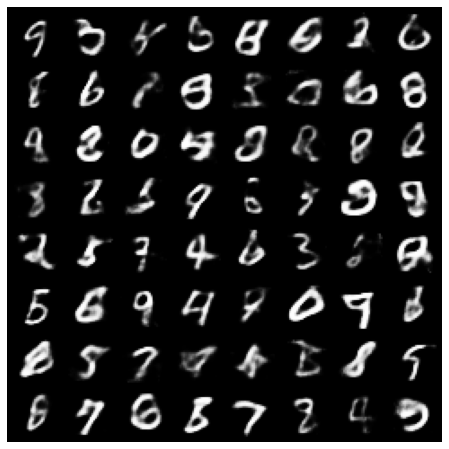

In [29]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(img.imread('results/sample_' + str(epoch) + '.png'), animated=True)] for epoch in range(1, epochs + 1)]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())